In [4]:
import sys
sys.path.append('../')
from prs.gwasimulator.GWASSimulator import GWASSimulator
from prs.gwasimulator.GWASDataLoader import GWASDataLoader
import numpy as np
import pandas as pd
import dask.array as da
import copy
import os
import scipy
from tqdm import tqdm
#from prs_models import *
#from evaluation import *
from prs.plotting import *
from prs.gwasimulator.c_utils import *
from prs.gwasimulator.plotting import *
from prs.src.vem_c import vem_prs
from prs.src.vem_c_sbayes import vem_prs_sbayes
from prs.src.vem_c_w_priors import vem_prs_wp
from prs.src.vem_c_opt import vem_prs_opt
from prs.src.gibbs_c import prs_gibbs
from prs.src.gibbs_c_sbayes import prs_gibbs_sbayes
from prs.src.vem_c_sbayes_opt import vem_prs_sbayes_opt
from prs.ext.prs_models import *
from prs.ext.snp_heritability_models import *
from prs.eval.evaluation import *
import humanize
import psutil
%load_ext autoreload
%autoreload 2
%load_ext Cython

In [42]:
GWASDataLoader("../../data/1000G_EUR_Phase3_plink/1000G.EUR.QC.22.bed",
               keep_snps="../../data/ukbb_qc_variants_hm3.keep",
               sumstats_file="../../data/chr_22.PHENO1.glm.linear")

0it [00:00, ?it/s]

> Reading genotype files...
(489, 17437)


1it [00:03,  3.10s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

> Computing LD boundaries...
> Computing LD matrices...


100%|██████████| 1/1 [00:00<00:00, 30.27it/s]

> Harmonizing data...
> Computing LD boundaries...


IndexError: too many indices for array

In [40]:
pd.read_csv("../../data/ukbb_qc_variants_hm3.keep", header=None)

,0
0,rs7766035
1,rs11757325
2,rs9392298
3,rs9392299
4,rs9405486
...,...
1184065,rs6599557
1184066,rs6599560
1184067,rs7008265
1184068,rs6991681


In [29]:
df = pd.read_csv("../../data/chr_22.PHENO1.glm.linear", sep="\t")
df

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P
0,22,16886873,rs7287144,A,G,G,ADD,220835,-0.001900,0.003394,-0.559817,5.756050e-01
1,22,16892858,rs5748662,G,A,A,ADD,220446,-0.002164,0.003401,-0.636254,5.246120e-01
2,22,16894264,rs4010554,C,A,A,ADD,229276,-0.003399,0.003254,-1.044630,2.961970e-01
3,22,16896762,rs4010558,G,A,A,ADD,229252,-0.003139,0.003255,-0.964451,3.348210e-01
4,22,17030792,rs2379981,A,G,G,ADD,223079,-0.035504,0.007108,-4.995070,5.886000e-07
...,...,...,...,...,...,...,...,...,...,...,...,...
16567,22,51165664,rs8137951,G,A,A,ADD,229756,-0.007764,0.003211,-2.417820,1.561460e-02
16568,22,51171497,rs2301584,G,A,A,ADD,229756,0.001162,0.003943,0.294634,7.682740e-01
16569,22,51175626,rs3810648,A,G,G,ADD,229756,0.019168,0.006186,3.098580,1.944760e-03
16570,22,51178090,rs2285395,G,A,A,ADD,227945,0.026465,0.006713,3.942650,8.061000e-05


In [23]:
len(df.loc[df['ID'].isin(snps)])

34

# Simple Example (real genotypes)

In [2]:
gs_w = GWASSimulator("../../data/1000G_EUR_Phase3_plink/1000G.EUR.QC.22.bed",
                       keep_snps="../../data/gctb_22_snps.csv", 
                   pis=(0., 1.),
                   h2g=0.5,
                   ld_estimator='windowed',
                   sparse_ld=True,
                   temp_dir='temp_w')
gs_w.simulate()

"""
gs_sa = GWASSimulator("../../data/1000G_EUR_Phase3_plink/1000G.EUR.QC.22.bed",
                   keep_snps="../../data/w_snplist_no_MHC.snplist.bz2", 
                   pis=(0.99, 0.01),
                   h2g=0.5,
                   ld_estimator='sample',
                   temp_dir='temp_s')
gs_sa.simulate()

gs_sh = GWASSimulator("../../data/1000G_EUR_Phase3_plink/1000G.EUR.QC.22.bed",
                   keep_snps="../../data/w_snplist_no_MHC.snplist.bz2", 
                   pis=(0.99, 0.01),
                   h2g=0.5,
                   ld_estimator='shrinkage',
                   temp_dir='temp_sh',
                   sparse_ld=True,
                   genmap_Ne=11400,
                   genmap_sample_size=183,
                   shrinkage_cutoff=1e-5)
gs_sh.simulate()
"""

0it [00:00, ?it/s]

> Reading genotype files...


1it [00:02,  2.54s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

> Computing LD boundaries...
> Computing LD matrices...


100%|██████████| 1/1 [00:17<00:00, 17.55s/it]


'\ngs_sa = GWASSimulator("../../data/1000G_EUR_Phase3_plink/1000G.EUR.QC.22.bed",\n                   keep_snps="../../data/w_snplist_no_MHC.snplist.bz2", \n                   pis=(0.99, 0.01),\n                   h2g=0.5,\n                   ld_estimator=\'sample\',\n                   temp_dir=\'temp_s\')\ngs_sa.simulate()\n\ngs_sh = GWASSimulator("../../data/1000G_EUR_Phase3_plink/1000G.EUR.QC.22.bed",\n                   keep_snps="../../data/w_snplist_no_MHC.snplist.bz2", \n                   pis=(0.99, 0.01),\n                   h2g=0.5,\n                   ld_estimator=\'shrinkage\',\n                   temp_dir=\'temp_sh\',\n                   sparse_ld=True,\n                   genmap_Ne=11400,\n                   genmap_sample_size=183,\n                   shrinkage_cutoff=1e-5)\ngs_sh.simulate()\n'

In [3]:
from prs.src.test import LDBlock, test_dot, test_my_dot, test_utils_my_dot

#block = LDBlock(gs_w.ld[22].store)
#block.load()

In [22]:
%timeit test_dot(block)

14.8 ms ± 380 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%timeit test_my_dot(block)

15 ms ± 242 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
%timeit test_utils_my_dot(block)

35.5 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [3]:
gs_w.load_ld()

In [4]:
block = LDBlock(gs_w.ld[22].store)
block.load()

gs_w.ld[22] = block

In [5]:
t = prs_gibbs_sbayes_test(gs_w)
%timeit t.sample_local_parameters()

17.3 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%timeit t.sample_local_parameters_3()

16.7 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
%prun t.sample_local_parameters_3()

In [16]:
%timeit t.sample_local_parameters_3_0()

17.7 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%timeit t.sample_local_parameters_3_1()

17.9 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%timeit t.sample_local_parameters_3_2()

18 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%timeit t.sample_local_parameters_3_3()

1.72 ms ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
%timeit t.sample_local_parameters_4()

36.8 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
pgbs_sb = prs_gibbs_sbayes(gs_w, beta_prior=(2., 10.), sigma_epsilon_prior=(100., 200.), fix_params={'pi': .05})
#pgbs_sb.fit(n_samples=10000, burn_in=2000)


In [10]:
%timeit pgbs_sb.sample_local_parameters()

38.3 ms ± 3.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
pgbs_sb.get_heritability()

0.3684783880989025

In [16]:
sb = SBayesR(gs_w, ldm="../external/gctb_2.0_tutorial/ldm/sparse/chr22/1000G_eur_chr22.ldm.sparse")
sb.fit()
sb.get_heritability()

0.762559

In [4]:
pgbs_sb = prs_gibbs_sbayes(gs_w, beta_prior=(1., 1.), sigma_epsilon_prior=(100., 100.))
pgbs_sb.fit(n_samples=10000, burn_in=2000)

ValueError: Domain error in arguments.

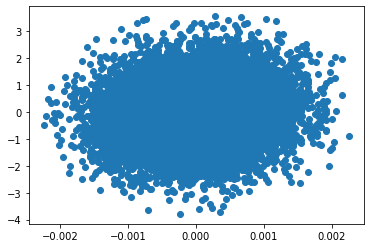

In [29]:
plt.scatter(pgbs_sb.inf_beta[22], gs_w.betas[22])

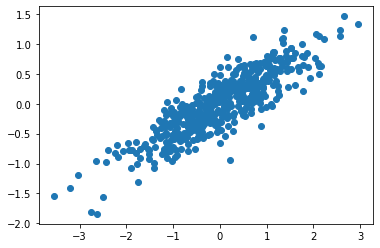

In [36]:
plt.scatter(gs_w.phenotypes, pgbs_sb.predict_phenotype())

Warning (Iteration 2): ELBO dropped from -683.307366 to -684.289900!
Max iterations reached without convergence. You may need to run the model for more iterations.


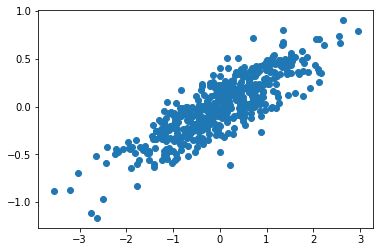

In [37]:
vw = vem_prs_sbayes(gs_w)
vw.fit(max_iter=500)

plt.scatter(gs_w.phenotypes, vw.predict_phenotype())

In [38]:
vw.get_heritabilitytability()

0.26496313858086556

Warning (Iteration 2): ELBO dropped from -529.895952 to -679.950540!
Warning (Iteration 79): ELBO dropped from -651.512873 to -651.514436!
Warning (Iteration 80): ELBO dropped from -651.514436 to -651.517660!
Warning (Iteration 81): ELBO dropped from -651.517660 to -651.522477!
Warning (Iteration 82): ELBO dropped from -651.522477 to -651.528822!
Warning (Iteration 83): ELBO dropped from -651.528822 to -651.536631!
Warning (Iteration 84): ELBO dropped from -651.536631 to -651.545844!
Warning (Iteration 85): ELBO dropped from -651.545844 to -651.556403!
Warning (Iteration 86): ELBO dropped from -651.556403 to -651.568253!
Warning (Iteration 87): ELBO dropped from -651.568253 to -651.581339!
Warning (Iteration 88): ELBO dropped from -651.581339 to -651.595612!
The optimization is halted due to numerical instabilities!


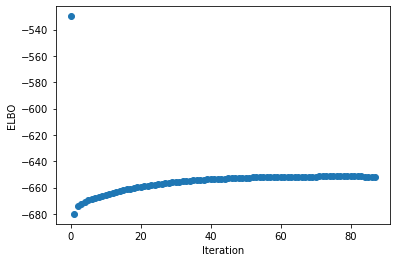

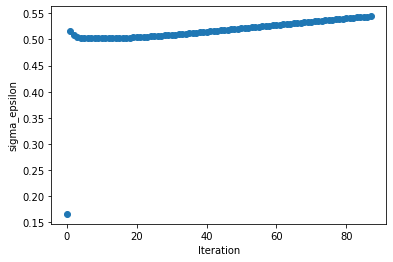

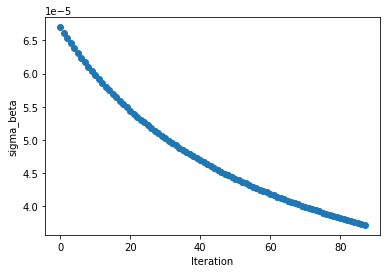

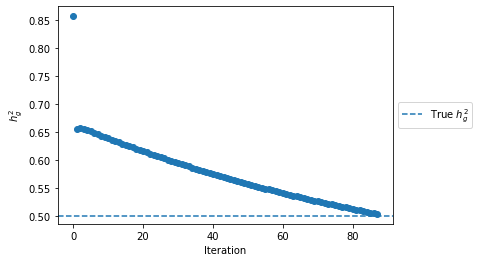

In [8]:
vwi = vem_prs_sbayes_inf(gs_w)
vwi.fit(max_iter=500)
plot_history(vwi)

Warning (Iteration 2): ELBO dropped from -689.031380 to -689.359578!
Max iterations reached without convergence. You may need to run the model for more iterations.


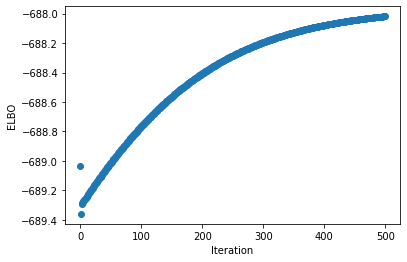

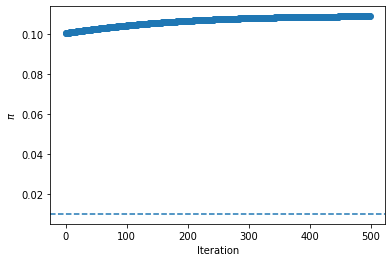

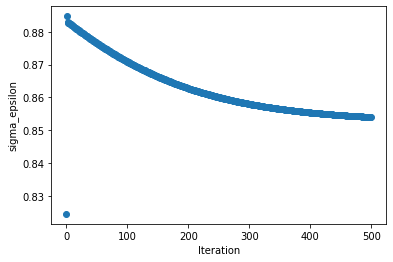

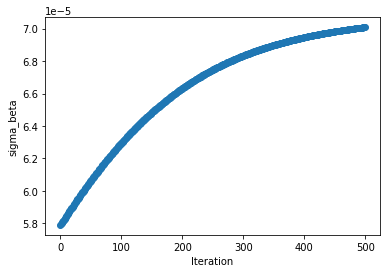

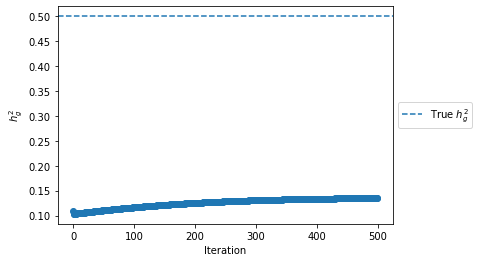

0.240169

In [135]:
gs_w.h2g = 0.5
gs_w.simulate()

vw = vem_prs_sbayes(gs_w)
vw.fit(max_iter=500)
plot_history(vw)

sb = SBayesR(gs_w,ldm="../external/gctb_2.0_tutorial/ldm/sparse/chr22/1000G_eur_chr22.ldm.sparse")
sb.fit()
sb.get_heritability()


In [75]:
gs_w.h2g = 0.1
res = evaluate_prediction_w_simulations([SBayesR(gs_w,ldm="../external/gctb_2.0_tutorial/ldm/sparse/chr22/1000G_eur_chr22.ldm.sparse"),
                                   vem_prs_sbayes_opt(gs_w)], gs_w, n_traits=10, k=3)

  0%|          | 0/10 [00:00<?, ?it/s]

> Processing Trait 0
Cross validation iteration 0
Max iterations reached without convergence. You may need to run the model for more iterations.
Cross validation iteration 1
Max iterations reached without convergence. You may need to run the model for more iterations.
Cross validation iteration 2
Max iterations reached without convergence. You may need to run the model for more iterations.


 10%|█         | 1/10 [08:40<1:18:01, 520.18s/it]

> Processing Trait 1
Cross validation iteration 0
Max iterations reached without convergence. You may need to run the model for more iterations.
Cross validation iteration 1
Max iterations reached without convergence. You may need to run the model for more iterations.
Cross validation iteration 2
Max iterations reached without convergence. You may need to run the model for more iterations.


 20%|██        | 2/10 [17:49<1:10:31, 528.98s/it]

> Processing Trait 2
Cross validation iteration 0
Max iterations reached without convergence. You may need to run the model for more iterations.
Cross validation iteration 1
Max iterations reached without convergence. You may need to run the model for more iterations.
Cross validation iteration 2


 20%|██        | 2/10 [24:01<1:36:06, 720.82s/it]


KeyboardInterrupt: 

In [81]:
res

,Pooled R2,Average R2,Trait
SBayesR,0.069899,0.081720,0
vem_prs_sbayes,0.148044,0.156670,0
SBayesR,0.129715,0.132906,1
vem_prs_sbayes,0.155988,0.170535,1
SBayesR,0.084940,0.106816,2
vem_prs_sbayes,0.152514,0.160179,2


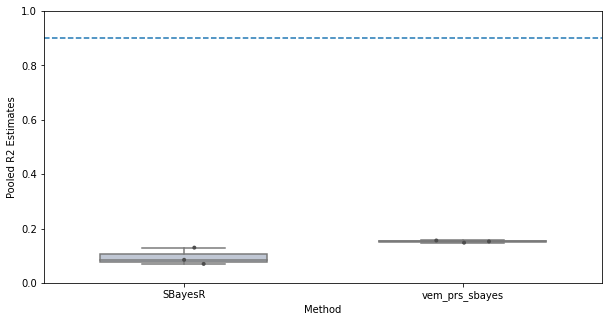

In [83]:
plot_prediction_results(res, true_h2g=gs_w.h2g)

In [7]:
def evaluate_heritability_w_simulations_2(h2, n_traits=10, max_iter=300):

    results = []
    
    gs_w.h2g = h2

    print("Evaluating Heritability with Simulations...")
    for _ in tqdm(range(n_traits)):
        gs_w.simulate(reset_beta=True)
        
        res = {}

        vw = vem_prs_sbayes(gs_w)
        vw.fit(max_iter=max_iter)
        res['Sparse'] = vw.get_heritability()
        
        vw_i = vem_prs_sbayes_inf(gs_w)
        vw_i.fit(max_iter=max_iter)
        res['Infinitesimal'] = vw_i.get_heritability()
        
        """
        sb = SBayesR(gs_w, ldm="../external/gctb_2.0_tutorial/ldm/sparse/chr22/1000G_eur_chr22.ldm.sparse")
        sb.fit()
        res['SBayesR'] = sb.get_heritability()
        
        he = HERegression(gs_w)
        he.fit()
        res['HEReg'] = he.get_heritability()
        """
        
        results.append(res)

    return pd.DataFrame(results)

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating Heritability with Simulations...
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -731.179187 to -754.887591!


 10%|█         | 1/10 [00:47<07:03, 47.11s/it]

Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 85): ELBO dropped from -693.549330 to -693.549331!
Converged at iteration 85 | ELBO: -693.549331
Warning (Iteration 2): ELBO dropped from -733.470238 to -754.918132!


 20%|██        | 2/10 [01:17<05:37, 42.15s/it]

Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 4): ELBO dropped from -693.474488 to -693.474565!
Warning (Iteration 65): ELBO dropped from -693.449660 to -693.449666!
Warning (Iteration 66): ELBO dropped from -693.449666 to -693.449680!
Warning (Iteration 67): ELBO dropped from -693.449680 to -693.449700!
Warning (Iteration 68): ELBO dropped from -693.449700 to -693.449728!
Warning (Iteration 69): ELBO dropped from -693.449728 to -693.449763!
Warning (Iteration 70): ELBO dropped from -693.449763 to -693.449804!
Warning (Iteration 71): ELBO dropped from -693.449804 to -693.449852!
Warning (Iteration 72): ELBO dropped from -693.449852 to -693.449906!
Warning (Iteration 73): ELBO dropped from -693.449906 to -693.449966!
Warning (Iteration 74): ELBO dropped from -693.449966 to -693.450033!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -739.047635 to -757.130406!


 30%|███       | 3/10 [01:47<04:28, 38.41s/it]

Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 4): ELBO dropped from -692.064500 to -692.068279!
Warning (Iteration 5): ELBO dropped from -692.068279 to -692.070986!
Warning (Iteration 6): ELBO dropped from -692.070986 to -692.073688!
Warning (Iteration 7): ELBO dropped from -692.073688 to -692.076375!
Warning (Iteration 8): ELBO dropped from -692.076375 to -692.079044!
Warning (Iteration 9): ELBO dropped from -692.079044 to -692.081696!
Warning (Iteration 10): ELBO dropped from -692.081696 to -692.084332!
Warning (Iteration 11): ELBO dropped from -692.084332 to -692.086950!
Warning (Iteration 12): ELBO dropped from -692.086950 to -692.089553!
Warning (Iteration 13): ELBO dropped from -692.089553 to -692.092138!
Warning (Iteration 14): ELBO dropped from -692.092138 to -692.094708!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -706.337629 to -741.242055!


 40%|████      | 4/10 [02:12<03:26, 34.39s/it]

Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -690.356734 to -690.485341!
Warning (Iteration 4): ELBO dropped from -690.429296 to -690.430411!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -687.368689 to -733.458942!


 50%|█████     | 5/10 [02:59<03:11, 38.20s/it]

Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -689.393055 to -689.668222!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -658.958265 to -723.593690!
Warning (Iteration 214): ELBO dropped from -684.127588 to -684.127632!
Warning (Iteration 215): ELBO dropped from -684.127632 to -684.127778!
Warning (Iteration 216): ELBO dropped from -684.127778 to -684.128023!
Warning (Iteration 217): ELBO dropped from -684.128023 to -684.128366!
Warning (Iteration 218): ELBO dropped from -684.128366 to -684.128804!
Warning (Iteration 219): ELBO dropped from -684.128804 to -684.129336!
Warning (Iteration 220): ELBO dropped from -684.129336 to -684.129960!
Warning (Iteration 221): ELBO dropped from -684.129960 to -684.130673!
Warning (Iteration 222): ELBO dropped from -684.130673 to -684.131475!


 60%|██████    | 6/10 [03:42<02:38, 39.61s/it]

Warning (Iteration 223): ELBO dropped from -684.131475 to -684.132363!
The optimization is halted due to numerical instabilities!
Warning (Iteration 4): ELBO dropped from -692.777658 to -692.780264!
Warning (Iteration 5): ELBO dropped from -692.780264 to -692.781785!
Warning (Iteration 6): ELBO dropped from -692.781785 to -692.783335!
Warning (Iteration 7): ELBO dropped from -692.783335 to -692.784882!
Warning (Iteration 8): ELBO dropped from -692.784882 to -692.786425!
Warning (Iteration 9): ELBO dropped from -692.786425 to -692.787966!
Warning (Iteration 10): ELBO dropped from -692.787966 to -692.789503!
Warning (Iteration 11): ELBO dropped from -692.789503 to -692.791037!
Warning (Iteration 12): ELBO dropped from -692.791037 to -692.792568!
Warning (Iteration 13): ELBO dropped from -692.792568 to -692.794095!
Warning (Iteration 14): ELBO dropped from -692.794095 to -692.795619!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -726.2

 70%|███████   | 7/10 [04:07<01:45, 35.28s/it]

Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 4): ELBO dropped from -692.533349 to -692.536288!
Warning (Iteration 5): ELBO dropped from -692.536288 to -692.538416!
Warning (Iteration 6): ELBO dropped from -692.538416 to -692.540534!
Warning (Iteration 7): ELBO dropped from -692.540534 to -692.542643!
Warning (Iteration 8): ELBO dropped from -692.542643 to -692.544742!
Warning (Iteration 9): ELBO dropped from -692.544742 to -692.546829!
Warning (Iteration 10): ELBO dropped from -692.546829 to -692.548907!
Warning (Iteration 11): ELBO dropped from -692.548907 to -692.550974!
Warning (Iteration 12): ELBO dropped from -692.550974 to -692.553030!
Warning (Iteration 13): ELBO dropped from -692.553030 to -692.555076!
Warning (Iteration 14): ELBO dropped from -692.555076 to -692.557112!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -719.476604 to -748.105661!


 80%|████████  | 8/10 [04:33<01:04, 32.37s/it]

Max iterations reached without convergence. You may need to run the model for more iterations.
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -738.568773 to -757.546361!


 90%|█████████ | 9/10 [05:20<00:36, 36.94s/it]

Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 4): ELBO dropped from -691.897533 to -691.901599!
Warning (Iteration 5): ELBO dropped from -691.901599 to -691.904221!
Warning (Iteration 6): ELBO dropped from -691.904221 to -691.906843!
Warning (Iteration 7): ELBO dropped from -691.906843 to -691.909452!
Warning (Iteration 8): ELBO dropped from -691.909452 to -691.912044!
Warning (Iteration 9): ELBO dropped from -691.912044 to -691.914621!
Warning (Iteration 10): ELBO dropped from -691.914621 to -691.917181!
Warning (Iteration 11): ELBO dropped from -691.917181 to -691.919725!
Warning (Iteration 12): ELBO dropped from -691.919725 to -691.922254!
Warning (Iteration 13): ELBO dropped from -691.922254 to -691.924767!
Warning (Iteration 14): ELBO dropped from -691.924767 to -691.927264!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -712.698105 to -744.923851!


100%|██████████| 10/10 [05:46<00:00, 34.67s/it]

Max iterations reached without convergence. You may need to run the model for more iterations.


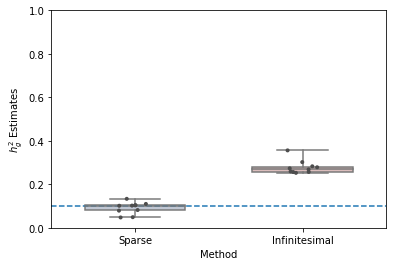

In [11]:
res_p1 = evaluate_heritability_w_simulations_2(0.1)
plot_heritability_boxplot(res_p1, true_h2=0.1)

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating Heritability with Simulations...
Warning (Iteration 2): ELBO dropped from -691.278180 to -691.313976!
Warning (Iteration 4): ELBO dropped from -691.263027 to -691.266841!
Warning (Iteration 5): ELBO dropped from -691.266841 to -691.269029!
Warning (Iteration 6): ELBO dropped from -691.269029 to -691.271252!
Warning (Iteration 7): ELBO dropped from -691.271252 to -691.273458!
Warning (Iteration 8): ELBO dropped from -691.273458 to -691.275651!
Warning (Iteration 9): ELBO dropped from -691.275651 to -691.277830!
Warning (Iteration 10): ELBO dropped from -691.277830 to -691.279995!
Warning (Iteration 11): ELBO dropped from -691.279995 to -691.282147!
Warning (Iteration 12): ELBO dropped from -691.282147 to -691.284285!
Warning (Iteration 13): ELBO dropped from -691.284285 to -691.286409!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -709.552246 to -743.030078!


 10%|█         | 1/10 [00:25<03:46, 25.16s/it]

Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -687.348252 to -687.816682!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -675.326544 to -724.875034!
Warning (Iteration 206): ELBO dropped from -680.357829 to -680.357911!
Warning (Iteration 207): ELBO dropped from -680.357911 to -680.358124!
Warning (Iteration 208): ELBO dropped from -680.358124 to -680.358466!
Warning (Iteration 209): ELBO dropped from -680.358466 to -680.358932!
Warning (Iteration 210): ELBO dropped from -680.358932 to -680.359521!
Warning (Iteration 211): ELBO dropped from -680.359521 to -680.360230!
Warning (Iteration 212): ELBO dropped from -680.360230 to -680.361057!
Warning (Iteration 213): ELBO dropped from -680.361057 to -680.361999!
Warning (Iteration 214): ELBO dropped from -680.361999 to -680.363053!


 20%|██        | 2/10 [01:06<04:01, 30.13s/it]

Warning (Iteration 215): ELBO dropped from -680.363053 to -680.364218!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -690.909314 to -691.015445!
Warning (Iteration 4): ELBO dropped from -690.969584 to -690.971619!
Warning (Iteration 5): ELBO dropped from -690.971619 to -690.972854!
Warning (Iteration 6): ELBO dropped from -690.972854 to -690.974057!
Warning (Iteration 7): ELBO dropped from -690.974057 to -690.975257!
Warning (Iteration 8): ELBO dropped from -690.975257 to -690.976450!
Warning (Iteration 9): ELBO dropped from -690.976450 to -690.977635!
Warning (Iteration 10): ELBO dropped from -690.977635 to -690.978814!
Warning (Iteration 11): ELBO dropped from -690.978814 to -690.979987!
Warning (Iteration 12): ELBO dropped from -690.979987 to -690.981152!
Warning (Iteration 13): ELBO dropped from -690.981152 to -690.982312!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -689.71

 30%|███       | 3/10 [01:31<03:19, 28.51s/it]

Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -686.978811 to -687.554455!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -633.432961 to -713.767336!
Warning (Iteration 148): ELBO dropped from -676.526929 to -676.527089!
Warning (Iteration 149): ELBO dropped from -676.527089 to -676.527562!
Warning (Iteration 150): ELBO dropped from -676.527562 to -676.528338!
Warning (Iteration 151): ELBO dropped from -676.528338 to -676.529409!
Warning (Iteration 152): ELBO dropped from -676.529409 to -676.530768!
Warning (Iteration 153): ELBO dropped from -676.530768 to -676.532406!
Warning (Iteration 154): ELBO dropped from -676.532406 to -676.534317!
Warning (Iteration 155): ELBO dropped from -676.534317 to -676.536492!
Warning (Iteration 156): ELBO dropped from -676.536492 to -676.538925!


 40%|████      | 4/10 [02:12<03:13, 32.18s/it]

Warning (Iteration 157): ELBO dropped from -676.538925 to -676.541608!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -687.448697 to -687.954991!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -635.551001 to -713.942746!
Warning (Iteration 157): ELBO dropped from -678.106667 to -678.106878!
Warning (Iteration 158): ELBO dropped from -678.106878 to -678.107346!
Warning (Iteration 159): ELBO dropped from -678.107346 to -678.108065!
Warning (Iteration 160): ELBO dropped from -678.108065 to -678.109030!
Warning (Iteration 161): ELBO dropped from -678.109030 to -678.110233!
Warning (Iteration 162): ELBO dropped from -678.110233 to -678.111668!
Warning (Iteration 163): ELBO dropped from -678.111668 to -678.113330!


 50%|█████     | 5/10 [02:53<02:54, 34.99s/it]

Warning (Iteration 164): ELBO dropped from -678.113330 to -678.115212!
Warning (Iteration 165): ELBO dropped from -678.115212 to -678.117309!
Warning (Iteration 166): ELBO dropped from -678.117309 to -678.119616!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -691.986446 to -691.996136!
Warning (Iteration 4): ELBO dropped from -691.959662 to -691.963037!
Warning (Iteration 5): ELBO dropped from -691.963037 to -691.965729!
Warning (Iteration 6): ELBO dropped from -691.965729 to -691.968391!
Warning (Iteration 7): ELBO dropped from -691.968391 to -691.971037!
Warning (Iteration 8): ELBO dropped from -691.971037 to -691.973667!
Warning (Iteration 9): ELBO dropped from -691.973667 to -691.976281!
Warning (Iteration 10): ELBO dropped from -691.976281 to -691.978877!
Warning (Iteration 11): ELBO dropped from -691.978877 to -691.981458!
Warning (Iteration 12): ELBO dropped from -691.981458 to -691.984022!
Warning (Iteration 13): ELBO droppe

 60%|██████    | 6/10 [03:22<02:12, 33.03s/it]

Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -690.115111 to -690.323016!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -655.675602 to -724.906955!
Warning (Iteration 232): ELBO dropped from -685.902600 to -685.902656!
Warning (Iteration 233): ELBO dropped from -685.902656 to -685.902787!
Warning (Iteration 234): ELBO dropped from -685.902787 to -685.902993!
Warning (Iteration 235): ELBO dropped from -685.902993 to -685.903272!
Warning (Iteration 236): ELBO dropped from -685.903272 to -685.903622!
Warning (Iteration 237): ELBO dropped from -685.903622 to -685.904043!
Warning (Iteration 238): ELBO dropped from -685.904043 to -685.904532!
Warning (Iteration 239): ELBO dropped from -685.904532 to -685.905089!


 70%|███████   | 7/10 [04:08<01:50, 36.91s/it]

Warning (Iteration 240): ELBO dropped from -685.905089 to -685.905713!
Warning (Iteration 241): ELBO dropped from -685.905713 to -685.906402!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -690.833425 to -690.926581!
Warning (Iteration 4): ELBO dropped from -690.875495 to -690.877713!
Warning (Iteration 5): ELBO dropped from -690.877713 to -690.878880!
Warning (Iteration 6): ELBO dropped from -690.878880 to -690.880033!
Warning (Iteration 7): ELBO dropped from -690.880033 to -690.881182!
Warning (Iteration 8): ELBO dropped from -690.881182 to -690.882324!
Warning (Iteration 9): ELBO dropped from -690.882324 to -690.883459!
Warning (Iteration 10): ELBO dropped from -690.883459 to -690.884588!
Warning (Iteration 11): ELBO dropped from -690.884588 to -690.885711!
Warning (Iteration 12): ELBO dropped from -690.885711 to -690.886827!
Warning (Iteration 13): ELBO dropped from -690.886827 to -690.887937!
The optimization is halted due to nu

 80%|████████  | 8/10 [04:35<01:08, 34.13s/it]

Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -685.988481 to -686.702366!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -605.114564 to -701.570936!
Warning (Iteration 116): ELBO dropped from -671.292144 to -671.292615!
Warning (Iteration 117): ELBO dropped from -671.292615 to -671.293673!
Warning (Iteration 118): ELBO dropped from -671.293673 to -671.295300!
Warning (Iteration 119): ELBO dropped from -671.295300 to -671.297477!
Warning (Iteration 120): ELBO dropped from -671.297477 to -671.300188!
Warning (Iteration 121): ELBO dropped from -671.300188 to -671.303413!
Warning (Iteration 122): ELBO dropped from -671.303413 to -671.307138!
Warning (Iteration 123): ELBO dropped from -671.307138 to -671.311346!


 90%|█████████ | 9/10 [05:13<00:35, 35.06s/it]

Warning (Iteration 124): ELBO dropped from -671.311346 to -671.316021!
Warning (Iteration 125): ELBO dropped from -671.316021 to -671.321149!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -686.357409 to -686.830927!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -663.413100 to -721.954369!
Warning (Iteration 194): ELBO dropped from -678.205920 to -678.205965!
Warning (Iteration 195): ELBO dropped from -678.205965 to -678.206166!
Warning (Iteration 196): ELBO dropped from -678.206166 to -678.206521!
Warning (Iteration 197): ELBO dropped from -678.206521 to -678.207026!
Warning (Iteration 198): ELBO dropped from -678.207026 to -678.207679!
Warning (Iteration 199): ELBO dropped from -678.207679 to -678.208475!
Warning (Iteration 200): ELBO dropped from -678.208475 to -678.209411!
Warning (Iteration 201): ELBO dropped from -678.209411 to -678.210486

100%|██████████| 10/10 [05:54<00:00, 35.40s/it]

Warning (Iteration 203): ELBO dropped from -678.211694 to -678.213035!
The optimization is halted due to numerical instabilities!


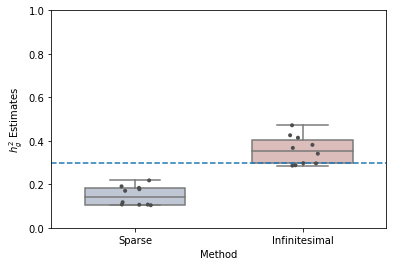

In [10]:
res_p3 = evaluate_heritability_w_simulations_2(0.3)
plot_heritability_boxplot(res_p3, true_h2=0.3)

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating Heritability with Simulations...
Warning (Iteration 2): ELBO dropped from -686.635935 to -687.240976!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -627.612760 to -711.061549!
Warning (Iteration 142): ELBO dropped from -675.442041 to -675.442059!
Warning (Iteration 143): ELBO dropped from -675.442059 to -675.442427!
Warning (Iteration 144): ELBO dropped from -675.442427 to -675.443136!
Warning (Iteration 145): ELBO dropped from -675.443136 to -675.444175!
Warning (Iteration 146): ELBO dropped from -675.444175 to -675.445535!
Warning (Iteration 147): ELBO dropped from -675.445535 to -675.447209!
Warning (Iteration 148): ELBO dropped from -675.447209 to -675.449186!
Warning (Iteration 149): ELBO dropped from -675.449186 to -675.451459!


 10%|█         | 1/10 [00:37<05:34, 37.12s/it]

Warning (Iteration 150): ELBO dropped from -675.451459 to -675.454019!
Warning (Iteration 151): ELBO dropped from -675.454019 to -675.456859!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -677.875326 to -679.740481!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -403.130716 to -657.413283!
Warning (Iteration 55): ELBO dropped from -633.824522 to -633.827029!
Warning (Iteration 56): ELBO dropped from -633.827029 to -633.833105!
Warning (Iteration 57): ELBO dropped from -633.833105 to -633.842573!
Warning (Iteration 58): ELBO dropped from -633.842573 to -633.855265!
Warning (Iteration 59): ELBO dropped from -633.855265 to -633.871021!
Warning (Iteration 60): ELBO dropped from -633.871021 to -633.889689!
Warning (Iteration 61): ELBO dropped from -633.889689 to -633.911123!


 20%|██        | 2/10 [01:08<04:42, 35.37s/it]

Warning (Iteration 62): ELBO dropped from -633.911123 to -633.935186!
Warning (Iteration 63): ELBO dropped from -633.935186 to -633.961746!
Warning (Iteration 64): ELBO dropped from -633.961746 to -633.990678!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -687.508287 to -688.062743!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -610.306187 to -709.311245!
Warning (Iteration 132): ELBO dropped from -676.266367 to -676.266568!
Warning (Iteration 133): ELBO dropped from -676.266568 to -676.267173!
Warning (Iteration 134): ELBO dropped from -676.267173 to -676.268168!
Warning (Iteration 135): ELBO dropped from -676.268168 to -676.269543!
Warning (Iteration 136): ELBO dropped from -676.269543 to -676.271286!
Warning (Iteration 137): ELBO dropped from -676.271286 to -676.273387!


 30%|███       | 3/10 [01:44<04:10, 35.72s/it]

Warning (Iteration 138): ELBO dropped from -676.273387 to -676.275835!
Warning (Iteration 139): ELBO dropped from -676.275835 to -676.278620!
Warning (Iteration 140): ELBO dropped from -676.278620 to -676.281732!
Warning (Iteration 141): ELBO dropped from -676.281732 to -676.285161!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -683.527910 to -684.546917!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -588.348427 to -698.252455!
Warning (Iteration 107): ELBO dropped from -664.999219 to -664.999369!
Warning (Iteration 108): ELBO dropped from -664.999369 to -665.000302!
Warning (Iteration 109): ELBO dropped from -665.000302 to -665.001991!
Warning (Iteration 110): ELBO dropped from -665.001991 to -665.004411!
Warning (Iteration 111): ELBO dropped from -665.004411 to -665.007536!
Warning (Iteration 112): ELBO dropped from -665.007536 to -665.011343

 40%|████      | 4/10 [02:19<03:31, 35.33s/it]

Warning (Iteration 115): ELBO dropped from -665.020912 to -665.026630!
Warning (Iteration 116): ELBO dropped from -665.026630 to -665.032941!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -685.402823 to -686.119449!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -610.221108 to -705.047271!
Warning (Iteration 126): ELBO dropped from -671.634131 to -671.634164!
Warning (Iteration 127): ELBO dropped from -671.634164 to -671.634682!
Warning (Iteration 128): ELBO dropped from -671.634682 to -671.635673!
Warning (Iteration 129): ELBO dropped from -671.635673 to -671.637121!
Warning (Iteration 130): ELBO dropped from -671.637121 to -671.639013!
Warning (Iteration 131): ELBO dropped from -671.639013 to -671.641335!
Warning (Iteration 132): ELBO dropped from -671.641335 to -671.644074!
Warning (Iteration 133): ELBO dropped from -671.644074 to -671.647219

 50%|█████     | 5/10 [02:55<02:57, 35.56s/it]

Warning (Iteration 134): ELBO dropped from -671.647219 to -671.650756!
Warning (Iteration 135): ELBO dropped from -671.650756 to -671.654674!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -685.696987 to -686.403618!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -615.771831 to -705.869707!
Warning (Iteration 127): ELBO dropped from -671.952603 to -671.952894!
Warning (Iteration 128): ELBO dropped from -671.952894 to -671.953663!
Warning (Iteration 129): ELBO dropped from -671.953663 to -671.954895!
Warning (Iteration 130): ELBO dropped from -671.954895 to -671.956578!
Warning (Iteration 131): ELBO dropped from -671.956578 to -671.958696!
Warning (Iteration 132): ELBO dropped from -671.958696 to -671.961239!
Warning (Iteration 133): ELBO dropped from -671.961239 to -671.964191!


 60%|██████    | 6/10 [03:31<02:22, 35.72s/it]

Warning (Iteration 134): ELBO dropped from -671.964191 to -671.967542!
Warning (Iteration 135): ELBO dropped from -671.967542 to -671.971279!
Warning (Iteration 136): ELBO dropped from -671.971279 to -671.975390!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -685.179826 to -685.971429!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -609.886726 to -705.733792!
Warning (Iteration 124): ELBO dropped from -670.506037 to -670.506402!
Warning (Iteration 125): ELBO dropped from -670.506402 to -670.507288!
Warning (Iteration 126): ELBO dropped from -670.507288 to -670.508679!
Warning (Iteration 127): ELBO dropped from -670.508679 to -670.510560!
Warning (Iteration 128): ELBO dropped from -670.510560 to -670.512915!
Warning (Iteration 129): ELBO dropped from -670.512915 to -670.515730!
Warning (Iteration 130): ELBO dropped from -670.515730 to -670.518991

 70%|███████   | 7/10 [04:07<01:47, 35.75s/it]

Warning (Iteration 132): ELBO dropped from -670.522685 to -670.526797!
Warning (Iteration 133): ELBO dropped from -670.526797 to -670.531315!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -680.886636 to -682.256017!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -494.664050 to -676.061481!
Warning (Iteration 70): ELBO dropped from -649.577001 to -649.577470!
Warning (Iteration 71): ELBO dropped from -649.577470 to -649.580026!
Warning (Iteration 72): ELBO dropped from -649.580026 to -649.584577!
Warning (Iteration 73): ELBO dropped from -649.584577 to -649.591036!
Warning (Iteration 74): ELBO dropped from -649.591036 to -649.599320!
Warning (Iteration 75): ELBO dropped from -649.599320 to -649.609350!
Warning (Iteration 76): ELBO dropped from -649.609350 to -649.621048!
Warning (Iteration 77): ELBO dropped from -649.621048 to -649.634343!


 80%|████████  | 8/10 [04:40<01:09, 34.83s/it]

Warning (Iteration 78): ELBO dropped from -649.634343 to -649.649163!
Warning (Iteration 79): ELBO dropped from -649.649163 to -649.665443!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -684.460698 to -685.352401!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -591.248800 to -700.071890!
Warning (Iteration 110): ELBO dropped from -667.396898 to -667.397090!
Warning (Iteration 111): ELBO dropped from -667.397090 to -667.397991!
Warning (Iteration 112): ELBO dropped from -667.397991 to -667.399578!
Warning (Iteration 113): ELBO dropped from -667.399578 to -667.401828!
Warning (Iteration 114): ELBO dropped from -667.401828 to -667.404719!
Warning (Iteration 115): ELBO dropped from -667.404719 to -667.408229!
Warning (Iteration 116): ELBO dropped from -667.408229 to -667.412338!


 90%|█████████ | 9/10 [05:15<00:34, 34.87s/it]

Warning (Iteration 117): ELBO dropped from -667.412338 to -667.417027!
Warning (Iteration 118): ELBO dropped from -667.417027 to -667.422275!
Warning (Iteration 119): ELBO dropped from -667.422275 to -667.428064!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -685.012726 to -685.765971!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -587.529678 to -699.795166!
Warning (Iteration 111): ELBO dropped from -668.282009 to -668.282540!
Warning (Iteration 112): ELBO dropped from -668.282540 to -668.283749!
Warning (Iteration 113): ELBO dropped from -668.283749 to -668.285613!
Warning (Iteration 114): ELBO dropped from -668.285613 to -668.288111!
Warning (Iteration 115): ELBO dropped from -668.288111 to -668.291220!
Warning (Iteration 116): ELBO dropped from -668.291220 to -668.294923!
Warning (Iteration 117): ELBO dropped from -668.294923 to -668.299197

100%|██████████| 10/10 [05:50<00:00, 35.03s/it]

Warning (Iteration 118): ELBO dropped from -668.299197 to -668.304025!
Warning (Iteration 119): ELBO dropped from -668.304025 to -668.309389!
Warning (Iteration 120): ELBO dropped from -668.309389 to -668.315270!
The optimization is halted due to numerical instabilities!


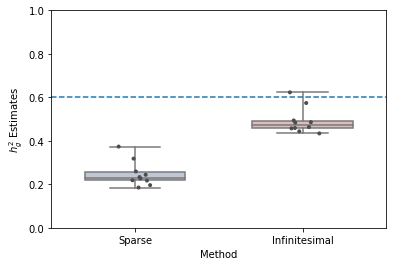

In [9]:
res_p6 = evaluate_heritability_w_simulations_2(0.6)
plot_heritability_boxplot(res_p6, true_h2=0.6)

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating Heritability with Simulations...
Warning (Iteration 2): ELBO dropped from -680.757068 to -682.083224!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -555.269738 to -684.533799!
Warning (Iteration 87): ELBO dropped from -655.234793 to -655.235065!
Warning (Iteration 88): ELBO dropped from -655.235065 to -655.236650!
Warning (Iteration 89): ELBO dropped from -655.236650 to -655.239498!
Warning (Iteration 90): ELBO dropped from -655.239498 to -655.243560!
Warning (Iteration 91): ELBO dropped from -655.243560 to -655.248790!
Warning (Iteration 92): ELBO dropped from -655.248790 to -655.255142!
Warning (Iteration 93): ELBO dropped from -655.255142 to -655.262574!
Warning (Iteration 94): ELBO dropped from -655.262574 to -655.271044!


 10%|█         | 1/10 [00:34<05:08, 34.32s/it]

Warning (Iteration 95): ELBO dropped from -655.271044 to -655.280511!
Warning (Iteration 96): ELBO dropped from -655.280511 to -655.290938!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -676.461502 to -678.645844!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from 964770642534.842896 to -625.809388!
Warning (Iteration 29): ELBO dropped from -610.485110 to -610.488747!
Warning (Iteration 30): ELBO dropped from -610.488747 to -610.501702!
Warning (Iteration 31): ELBO dropped from -610.501702 to -610.523391!
Warning (Iteration 32): ELBO dropped from -610.523391 to -610.553264!
Warning (Iteration 33): ELBO dropped from -610.553264 to -610.590806!
Warning (Iteration 34): ELBO dropped from -610.590806 to -610.635534!
Warning (Iteration 35): ELBO dropped from -610.635534 to -610.686993!


 20%|██        | 2/10 [01:04<04:24, 33.09s/it]

Warning (Iteration 36): ELBO dropped from -610.686993 to -610.744753!
Warning (Iteration 37): ELBO dropped from -610.744753 to -610.808414!
Warning (Iteration 38): ELBO dropped from -610.808414 to -610.877595!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -681.743452 to -683.025844!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -415.373965 to -666.816874!
Warning (Iteration 56): ELBO dropped from -645.850800 to -645.853511!
Warning (Iteration 57): ELBO dropped from -645.853511 to -645.859248!
Warning (Iteration 58): ELBO dropped from -645.859248 to -645.867862!
Warning (Iteration 59): ELBO dropped from -645.867862 to -645.879213!
Warning (Iteration 60): ELBO dropped from -645.879213 to -645.893167!
Warning (Iteration 61): ELBO dropped from -645.893167 to -645.909596!
Warning (Iteration 62): ELBO dropped from -645.909596 to -645.928379!
Warning 

 30%|███       | 3/10 [01:36<03:49, 32.77s/it]

Warning (Iteration 64): ELBO dropped from -645.949399 to -645.972547!
Warning (Iteration 65): ELBO dropped from -645.972547 to -645.997716!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -681.390297 to -682.759778!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -439.377012 to -667.106732!
Warning (Iteration 58): ELBO dropped from -645.834526 to -645.835649!
Warning (Iteration 59): ELBO dropped from -645.835649 to -645.839688!
Warning (Iteration 60): ELBO dropped from -645.839688 to -645.846506!
Warning (Iteration 61): ELBO dropped from -645.846506 to -645.855967!
Warning (Iteration 62): ELBO dropped from -645.855967 to -645.867946!
Warning (Iteration 63): ELBO dropped from -645.867946 to -645.882321!
Warning (Iteration 64): ELBO dropped from -645.882321 to -645.898978!
Warning (Iteration 65): ELBO dropped from -645.898978 to -645.917806!


 40%|████      | 4/10 [02:08<03:14, 32.43s/it]

Warning (Iteration 66): ELBO dropped from -645.917806 to -645.938702!
Warning (Iteration 67): ELBO dropped from -645.938702 to -645.961564!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -673.867679 to -676.474231!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from 141.762910 to -621.359245!
Warning (Iteration 31): ELBO dropped from -603.529919 to -603.530406!
Warning (Iteration 32): ELBO dropped from -603.530406 to -603.540224!
Warning (Iteration 33): ELBO dropped from -603.540224 to -603.558802!
Warning (Iteration 34): ELBO dropped from -603.558802 to -603.585600!
Warning (Iteration 35): ELBO dropped from -603.585600 to -603.620112!
Warning (Iteration 36): ELBO dropped from -603.620112 to -603.661860!
Warning (Iteration 37): ELBO dropped from -603.661860 to -603.710397!
Warning (Iteration 38): ELBO dropped from -603.710397 to -603.765299!
Warning (

 50%|█████     | 5/10 [02:40<02:41, 32.33s/it]

Warning (Iteration 2): ELBO dropped from -679.782233 to -681.413220!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -357.943956 to -656.353312!
Warning (Iteration 48): ELBO dropped from -636.838662 to -636.842780!
Warning (Iteration 49): ELBO dropped from -636.842780 to -636.851043!
Warning (Iteration 50): ELBO dropped from -636.851043 to -636.863234!
Warning (Iteration 51): ELBO dropped from -636.863234 to -636.879144!
Warning (Iteration 52): ELBO dropped from -636.879144 to -636.898579!
Warning (Iteration 53): ELBO dropped from -636.898579 to -636.921351!
Warning (Iteration 54): ELBO dropped from -636.921351 to -636.947285!
Warning (Iteration 55): ELBO dropped from -636.947285 to -636.976213!


 60%|██████    | 6/10 [03:11<02:07, 31.89s/it]

Warning (Iteration 56): ELBO dropped from -636.976213 to -637.007974!
Warning (Iteration 57): ELBO dropped from -637.007974 to -637.042419!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -684.685110 to -685.603014!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -560.638426 to -693.804233!
Warning (Iteration 93): ELBO dropped from -664.433982 to -664.434200!
Warning (Iteration 94): ELBO dropped from -664.434200 to -664.435465!
Warning (Iteration 95): ELBO dropped from -664.435465 to -664.437739!
Warning (Iteration 96): ELBO dropped from -664.437739 to -664.440984!
Warning (Iteration 97): ELBO dropped from -664.440984 to -664.445164!
Warning (Iteration 98): ELBO dropped from -664.445164 to -664.450245!
Warning (Iteration 99): ELBO dropped from -664.450245 to -664.456193!
Warning (Iteration 100): ELBO dropped from -664.456193 to -664.462977!


 70%|███████   | 7/10 [03:45<01:37, 32.48s/it]

Warning (Iteration 101): ELBO dropped from -664.462977 to -664.470564!
Warning (Iteration 102): ELBO dropped from -664.470564 to -664.478926!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -672.151134 to -674.981406!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from 880.597091 to -618.341254!
Warning (Iteration 31): ELBO dropped from -600.293633 to -600.299087!
Warning (Iteration 32): ELBO dropped from -600.299087 to -600.313717!
Warning (Iteration 33): ELBO dropped from -600.313717 to -600.336959!
Warning (Iteration 34): ELBO dropped from -600.336959 to -600.368280!
Warning (Iteration 35): ELBO dropped from -600.368280 to -600.407184!
Warning (Iteration 36): ELBO dropped from -600.407184 to -600.453199!
Warning (Iteration 37): ELBO dropped from -600.453199 to -600.505883!
Warning (Iteration 38): ELBO dropped from -600.505883 to -600.564820!


 80%|████████  | 8/10 [04:14<01:03, 31.67s/it]

Warning (Iteration 39): ELBO dropped from -600.564820 to -600.629619!
Warning (Iteration 40): ELBO dropped from -600.629619 to -600.699908!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -677.131335 to -679.189045!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -118.253631 to -637.064331!
Warning (Iteration 35): ELBO dropped from -618.856090 to -618.856484!
Warning (Iteration 36): ELBO dropped from -618.856484 to -618.864155!
Warning (Iteration 37): ELBO dropped from -618.864155 to -618.878675!
Warning (Iteration 38): ELBO dropped from -618.878675 to -618.899641!
Warning (Iteration 39): ELBO dropped from -618.899641 to -618.926672!
Warning (Iteration 40): ELBO dropped from -618.926672 to -618.959409!
Warning (Iteration 41): ELBO dropped from -618.959409 to -618.997513!
Warning (Iteration 42): ELBO dropped from -618.997513 to -619.040665!


 90%|█████████ | 9/10 [04:44<00:31, 31.21s/it]

Warning (Iteration 43): ELBO dropped from -619.040665 to -619.088563!
Warning (Iteration 44): ELBO dropped from -619.088563 to -619.140923!
The optimization is halted due to numerical instabilities!
Warning (Iteration 2): ELBO dropped from -679.847719 to -681.379747!
Max iterations reached without convergence. You may need to run the model for more iterations.
Warning (Iteration 2): ELBO dropped from -394.314520 to -657.355082!
Warning (Iteration 50): ELBO dropped from -637.807046 to -637.810008!
Warning (Iteration 51): ELBO dropped from -637.810008 to -637.816831!
Warning (Iteration 52): ELBO dropped from -637.816831 to -637.827317!
Warning (Iteration 53): ELBO dropped from -637.827317 to -637.841277!
Warning (Iteration 54): ELBO dropped from -637.841277 to -637.858533!
Warning (Iteration 55): ELBO dropped from -637.858533 to -637.878914!
Warning (Iteration 56): ELBO dropped from -637.878914 to -637.902258!
Warning (Iteration 57): ELBO dropped from -637.902258 to -637.928412!
Warning 

100%|██████████| 10/10 [05:16<00:00, 31.62s/it]

Warning (Iteration 59): ELBO dropped from -637.957229 to -637.988571!
The optimization is halted due to numerical instabilities!


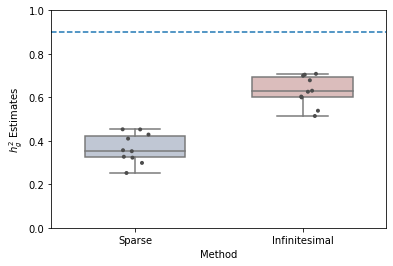

In [8]:
res_p9 = evaluate_heritability_w_simulations_2(0.9)
plot_heritability_boxplot(res_p9, true_h2=0.9)

In [11]:
def h2g_approach2(v):
    
    diag = np.sum([
                np.sum((v.var_gamma[c]*v.var_mu_beta[c])**2)
                for c in v.var_gamma
            ])
    
    off_diag = np.sum([
        np.dot(v.q[c], v.var_gamma[c] * v.var_mu_beta[c])
        for c in v.var_gamma
    ])
    
    sigma_g = diag + off_diag

    return sigma_g / (sigma_g + v.sigma_epsilon)
    
    

def h2g_approach1(v):
    
    diag = np.sum([
            np.sum(v.var_gamma[c] * (v.var_mu_beta[c]**2 + v.var_sigma_beta[c]))
            for c in v.var_gamma
        ])
    
    off_diag = np.sum([
        np.dot(v.q[c], v.var_gamma[c] * v.var_mu_beta[c])
        for c in v.var_gamma
    ])

    sigma_g = diag + off_diag

    return sigma_g / (sigma_g + v.sigma_epsilon)

def h2g_approach1_ld_prod(v):
    
    diag = np.sum([
            np.sum(v.var_gamma[c] * (v.var_mu_beta[c]**2 + v.var_sigma_beta[c]))
            for c in v.var_gamma
        ])
    
    off_diag = v.ld_prod

    sigma_g = diag + off_diag

    return sigma_g / (sigma_g + v.sigma_epsilon)


def h2g_sampling_approach(v, n_samples=100):
    
    h = []
    
    for _ in range(n_samples):
        beta = np.random.normal(v.var_mu_beta[22], np.sqrt(v.var_sigma_beta[22]))
        beta *= np.random.binomial(1, v.var_gamma[22])
        h.append(np.var(da.dot(v.gdl.genotypes[22]['G'], beta), ddof=1).compute())
    
    sigma_g = np.mean(h)
    
    return sigma_g / (sigma_g + v.sigma_epsilon)

    
def evaluate_heritability_w_simulations(h2, n_traits=5, max_iter=200):

    results = []
    
    gs_w.h2g = h2

    print("Evaluating Heritability with Simulations...")
    for _ in tqdm(range(n_traits)):
        gs_w.simulate(reset_beta=True)
        
        res = {}

        vw = vem_prs_sbayes_opt(gs_w)
        vw.fit(max_iter=max_iter)
        res['Approach 0'] = vw.get_heritability()
        #res['Approach 1'] = h2g_approach1(vw)
        #res['Approach 2'] = h2g_approach2(vw)
        #res['Approach 3'] = h2g_sampling_approach(vw)
        
        pgbs_sb = prs_gibbs_sbayes(gs_w, beta_prior=(2., 10.), sigma_epsilon_prior=(100., 200.))
        pgbs_sb.fit(n_samples=10000, burn_in=2000)
        res['Gibbs'] = pgbs_sb.get_heritability()
        
        sb = SBayesR(gs_w, ldm="../external/gctb_2.0_tutorial/ldm/sparse/chr22/1000G_eur_chr22.ldm.sparse")
        sb.fit()
        res['SBayesR'] = sb.get_heritability()
        
        he = HERegression(gs_w)
        he.fit()
        res['HEReg'] = he.get_heritability()
        
        results.append(res)

    return pd.DataFrame(results)

In [234]:
v_sb = vem_prs_sbayes(gs_w)
v_sb.fit(max_iter=300)

v_sb_opt = vem_prs_sbayes_opt(gs_w)
v_sb_opt.fit(max_iter=300)

v_sb.get_heritability(), h2g_approach1_ld_prod(v_sb), v_sb_opt.get_heritability(), h2g_approach1(v_sb_opt), h2g_sampling_approach(v_sb_opt)

Warning (Iteration 4): ELBO dropped from -692.922367 to -692.924578!
Warning (Iteration 5): ELBO dropped from -692.924578 to -692.925621!
Warning (Iteration 6): ELBO dropped from -692.925621 to -692.926696!
Warning (Iteration 7): ELBO dropped from -692.926696 to -692.927776!
Warning (Iteration 8): ELBO dropped from -692.927776 to -692.928860!
Warning (Iteration 9): ELBO dropped from -692.928860 to -692.929948!
Warning (Iteration 10): ELBO dropped from -692.929948 to -692.931040!
Warning (Iteration 11): ELBO dropped from -692.931040 to -692.932134!
Warning (Iteration 12): ELBO dropped from -692.932134 to -692.933232!
Warning (Iteration 13): ELBO dropped from -692.933232 to -692.934333!
Warning (Iteration 14): ELBO dropped from -692.934333 to -692.935436!
The optimization is halted due to numerical instabilities!
Warning (Iteration 4): ELBO dropped from -692.922367 to -692.924578!
Warning (Iteration 5): ELBO dropped from -692.924578 to -692.925621!
Warning (Iteration 6): ELBO dropped fro

(0.10100848408524798,
 0.10100848408524798,
 0.10100848638491579,
 0.10100848638491579,
 0.11101176750993044)

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating Heritability with Simulations...
Max iterations reached without convergence. You may need to run the model for more iterations.


 10%|█         | 1/10 [02:02<18:20, 122.31s/it]

Warning (Iteration 89): ELBO dropped from -693.538202 to -693.538202!
Converged at iteration 89 | ELBO: -693.538202


 20%|██        | 2/10 [03:58<16:03, 120.47s/it]

Warning (Iteration 4): ELBO dropped from -691.435508 to -691.439250!
Warning (Iteration 5): ELBO dropped from -691.439250 to -691.441680!
Warning (Iteration 6): ELBO dropped from -691.441680 to -691.444129!
Warning (Iteration 7): ELBO dropped from -691.444129 to -691.446561!
Warning (Iteration 8): ELBO dropped from -691.446561 to -691.448978!
Warning (Iteration 9): ELBO dropped from -691.448978 to -691.451379!
Warning (Iteration 10): ELBO dropped from -691.451379 to -691.453765!
Warning (Iteration 11): ELBO dropped from -691.453765 to -691.456135!
Warning (Iteration 12): ELBO dropped from -691.456135 to -691.458490!
Warning (Iteration 13): ELBO dropped from -691.458490 to -691.460830!
Warning (Iteration 14): ELBO dropped from -691.460830 to -691.463155!
The optimization is halted due to numerical instabilities!


 30%|███       | 3/10 [05:50<13:45, 117.88s/it]

Warning (Iteration 4): ELBO dropped from -693.170043 to -693.171868!
Warning (Iteration 5): ELBO dropped from -693.171868 to -693.173301!
Warning (Iteration 6): ELBO dropped from -693.173301 to -693.174725!
Warning (Iteration 7): ELBO dropped from -693.174725 to -693.176142!
Warning (Iteration 8): ELBO dropped from -693.176142 to -693.177554!
Warning (Iteration 9): ELBO dropped from -693.177554 to -693.178960!
Warning (Iteration 10): ELBO dropped from -693.178960 to -693.180360!
Warning (Iteration 11): ELBO dropped from -693.180360 to -693.181754!
Warning (Iteration 12): ELBO dropped from -693.181754 to -693.183142!
Warning (Iteration 13): ELBO dropped from -693.183142 to -693.184524!
Warning (Iteration 14): ELBO dropped from -693.184524 to -693.185901!
The optimization is halted due to numerical instabilities!


 40%|████      | 4/10 [07:38<11:29, 114.98s/it]

Warning (Iteration 4): ELBO dropped from -692.834964 to -692.837783!
Warning (Iteration 5): ELBO dropped from -692.837783 to -692.839939!
Warning (Iteration 6): ELBO dropped from -692.839939 to -692.842090!
Warning (Iteration 7): ELBO dropped from -692.842090 to -692.844229!
Warning (Iteration 8): ELBO dropped from -692.844229 to -692.846355!
Warning (Iteration 9): ELBO dropped from -692.846355 to -692.848469!
Warning (Iteration 10): ELBO dropped from -692.848469 to -692.850569!
Warning (Iteration 11): ELBO dropped from -692.850569 to -692.852657!
Warning (Iteration 12): ELBO dropped from -692.852657 to -692.854733!
Warning (Iteration 13): ELBO dropped from -692.854733 to -692.856796!
Warning (Iteration 14): ELBO dropped from -692.856796 to -692.858847!
The optimization is halted due to numerical instabilities!


 50%|█████     | 5/10 [09:29<09:29, 113.82s/it]

Warning (Iteration 4): ELBO dropped from -693.134891 to -693.136354!
Warning (Iteration 5): ELBO dropped from -693.136354 to -693.137145!
Warning (Iteration 6): ELBO dropped from -693.137145 to -693.137944!
Warning (Iteration 7): ELBO dropped from -693.137944 to -693.138750!
Warning (Iteration 8): ELBO dropped from -693.138750 to -693.139560!
Warning (Iteration 9): ELBO dropped from -693.139560 to -693.140376!
Warning (Iteration 10): ELBO dropped from -693.140376 to -693.141196!
Warning (Iteration 11): ELBO dropped from -693.141196 to -693.142020!
Warning (Iteration 12): ELBO dropped from -693.142020 to -693.142849!
Warning (Iteration 13): ELBO dropped from -693.142849 to -693.143681!
Warning (Iteration 14): ELBO dropped from -693.143681 to -693.144517!
The optimization is halted due to numerical instabilities!


 60%|██████    | 6/10 [11:22<07:34, 113.59s/it]

Warning (Iteration 2): ELBO dropped from -691.223812 to -691.269051!
Warning (Iteration 4): ELBO dropped from -691.221099 to -691.224560!
Warning (Iteration 5): ELBO dropped from -691.224560 to -691.226558!
Warning (Iteration 6): ELBO dropped from -691.226558 to -691.228591!
Warning (Iteration 7): ELBO dropped from -691.228591 to -691.230610!
Warning (Iteration 8): ELBO dropped from -691.230610 to -691.232616!
Warning (Iteration 9): ELBO dropped from -691.232616 to -691.234609!
Warning (Iteration 10): ELBO dropped from -691.234609 to -691.236590!
Warning (Iteration 11): ELBO dropped from -691.236590 to -691.238558!
Warning (Iteration 12): ELBO dropped from -691.238558 to -691.240514!
Warning (Iteration 13): ELBO dropped from -691.240514 to -691.242458!
The optimization is halted due to numerical instabilities!


 70%|███████   | 7/10 [13:14<05:39, 113.17s/it]

Warning (Iteration 151): ELBO dropped from -693.669320 to -693.669320!
Converged at iteration 151 | ELBO: -693.669320


 80%|████████  | 8/10 [15:14<03:50, 115.24s/it]

Warning (Iteration 4): ELBO dropped from -692.961386 to -692.963302!
Warning (Iteration 5): ELBO dropped from -692.963302 to -692.964165!
Warning (Iteration 6): ELBO dropped from -692.964165 to -692.965059!
Warning (Iteration 7): ELBO dropped from -692.965059 to -692.965960!
Warning (Iteration 8): ELBO dropped from -692.965960 to -692.966868!
Warning (Iteration 9): ELBO dropped from -692.966868 to -692.967783!
Warning (Iteration 10): ELBO dropped from -692.967783 to -692.968704!
Warning (Iteration 11): ELBO dropped from -692.968704 to -692.969631!
Warning (Iteration 12): ELBO dropped from -692.969631 to -692.970563!
Warning (Iteration 13): ELBO dropped from -692.970563 to -692.971501!
Warning (Iteration 14): ELBO dropped from -692.971501 to -692.972444!
The optimization is halted due to numerical instabilities!


 90%|█████████ | 9/10 [17:02<01:52, 112.79s/it]

Warning (Iteration 2): ELBO dropped from -691.817709 to -691.840581!
Warning (Iteration 4): ELBO dropped from -691.802146 to -691.805677!
Warning (Iteration 5): ELBO dropped from -691.805677 to -691.808224!
Warning (Iteration 6): ELBO dropped from -691.808224 to -691.810773!
Warning (Iteration 7): ELBO dropped from -691.810773 to -691.813306!
Warning (Iteration 8): ELBO dropped from -691.813306 to -691.815824!
Warning (Iteration 9): ELBO dropped from -691.815824 to -691.818325!
Warning (Iteration 10): ELBO dropped from -691.818325 to -691.820811!
Warning (Iteration 11): ELBO dropped from -691.820811 to -691.823281!
Warning (Iteration 12): ELBO dropped from -691.823281 to -691.825735!
Warning (Iteration 13): ELBO dropped from -691.825735 to -691.828174!
The optimization is halted due to numerical instabilities!


100%|██████████| 10/10 [18:54<00:00, 113.44s/it]


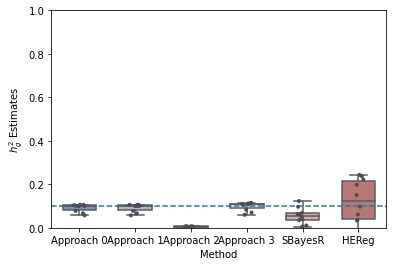

In [253]:
res_p1 = evaluate_heritability_w_simulations(0.1, 10)
plot_heritability_boxplot(res_p1, true_h2=0.1)

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating Heritability with Simulations...
Warning (Iteration 4): ELBO dropped from -692.256083 to -692.259178!
Warning (Iteration 5): ELBO dropped from -692.259178 to -692.261759!
Warning (Iteration 6): ELBO dropped from -692.261759 to -692.264316!
Warning (Iteration 7): ELBO dropped from -692.264316 to -692.266857!
Warning (Iteration 8): ELBO dropped from -692.266857 to -692.269382!
Warning (Iteration 9): ELBO dropped from -692.269382 to -692.271891!
Warning (Iteration 10): ELBO dropped from -692.271891 to -692.274384!
Warning (Iteration 11): ELBO dropped from -692.274384 to -692.276862!
Warning (Iteration 12): ELBO dropped from -692.276862 to -692.279325!
Warning (Iteration 13): ELBO dropped from -692.279325 to -692.281772!
Warning (Iteration 14): ELBO dropped from -692.281772 to -692.284204!
The optimization is halted due to numerical instabilities!


 10%|█         | 1/10 [01:50<16:35, 110.66s/it]

Warning (Iteration 2): ELBO dropped from -689.501187 to -689.743374!
Max iterations reached without convergence. You may need to run the model for more iterations.


 20%|██        | 2/10 [03:53<15:14, 114.27s/it]

Warning (Iteration 2): ELBO dropped from -690.586240 to -690.650038!
Warning (Iteration 4): ELBO dropped from -690.586864 to -690.589759!
Warning (Iteration 5): ELBO dropped from -690.589759 to -690.590748!
Warning (Iteration 6): ELBO dropped from -690.590748 to -690.591771!
Warning (Iteration 7): ELBO dropped from -690.591771 to -690.592792!
Warning (Iteration 8): ELBO dropped from -690.592792 to -690.593806!
Warning (Iteration 9): ELBO dropped from -690.593806 to -690.594813!
Warning (Iteration 10): ELBO dropped from -690.594813 to -690.595814!
Warning (Iteration 11): ELBO dropped from -690.595814 to -690.596810!
Warning (Iteration 12): ELBO dropped from -690.596810 to -690.597799!
Warning (Iteration 13): ELBO dropped from -690.597799 to -690.598782!
The optimization is halted due to numerical instabilities!


 30%|███       | 3/10 [05:44<13:13, 113.32s/it]

Warning (Iteration 2): ELBO dropped from -687.771590 to -688.174309!
Max iterations reached without convergence. You may need to run the model for more iterations.


 40%|████      | 4/10 [07:49<11:40, 116.73s/it]

Warning (Iteration 2): ELBO dropped from -689.753211 to -689.964069!
Max iterations reached without convergence. You may need to run the model for more iterations.


 50%|█████     | 5/10 [09:49<09:48, 117.77s/it]

Warning (Iteration 2): ELBO dropped from -689.365173 to -689.574928!
Max iterations reached without convergence. You may need to run the model for more iterations.


 60%|██████    | 6/10 [11:53<07:59, 119.80s/it]

Warning (Iteration 2): ELBO dropped from -688.275712 to -688.659983!
Max iterations reached without convergence. You may need to run the model for more iterations.


 70%|███████   | 7/10 [13:59<06:04, 121.46s/it]

Warning (Iteration 2): ELBO dropped from -688.532978 to -688.890924!
Max iterations reached without convergence. You may need to run the model for more iterations.


 80%|████████  | 8/10 [16:00<04:02, 121.31s/it]

Warning (Iteration 2): ELBO dropped from -688.575337 to -688.961011!
Max iterations reached without convergence. You may need to run the model for more iterations.


 90%|█████████ | 9/10 [18:05<02:02, 122.45s/it]

Warning (Iteration 2): ELBO dropped from -684.764596 to -685.608276!
Max iterations reached without convergence. You may need to run the model for more iterations.


100%|██████████| 10/10 [20:07<00:00, 120.73s/it]


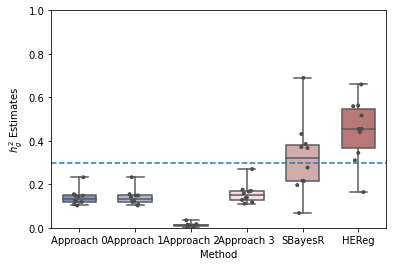

In [252]:
res_p3 = evaluate_heritability_w_simulations(0.3, 10)
plot_heritability_boxplot(res_p3, true_h2=0.3)

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating Heritability with Simulations...
Warning (Iteration 2): ELBO dropped from -685.948953 to -686.680548!
Max iterations reached without convergence. You may need to run the model for more iterations.


 10%|█         | 1/10 [02:08<19:19, 128.79s/it]

Warning (Iteration 2): ELBO dropped from -687.479282 to -687.961877!
Max iterations reached without convergence. You may need to run the model for more iterations.


 20%|██        | 2/10 [04:14<17:03, 128.00s/it]

Warning (Iteration 2): ELBO dropped from -686.345565 to -686.982173!
Max iterations reached without convergence. You may need to run the model for more iterations.


 30%|███       | 3/10 [06:22<14:54, 127.75s/it]

Warning (Iteration 2): ELBO dropped from -688.880415 to -689.213447!
Max iterations reached without convergence. You may need to run the model for more iterations.


 40%|████      | 4/10 [08:24<12:37, 126.28s/it]

Warning (Iteration 2): ELBO dropped from -686.966624 to -687.494589!
Max iterations reached without convergence. You may need to run the model for more iterations.


 50%|█████     | 5/10 [10:29<10:28, 125.65s/it]

Warning (Iteration 2): ELBO dropped from -687.608819 to -688.103562!
Max iterations reached without convergence. You may need to run the model for more iterations.


 60%|██████    | 6/10 [12:33<08:20, 125.15s/it]

Warning (Iteration 2): ELBO dropped from -684.371426 to -685.205512!
Max iterations reached without convergence. You may need to run the model for more iterations.


 70%|███████   | 7/10 [14:36<06:13, 124.47s/it]

Warning (Iteration 2): ELBO dropped from -678.214375 to -680.075178!
Max iterations reached without convergence. You may need to run the model for more iterations.


 80%|████████  | 8/10 [16:41<04:09, 124.82s/it]

Warning (Iteration 2): ELBO dropped from -682.654843 to -683.688147!
Max iterations reached without convergence. You may need to run the model for more iterations.


 90%|█████████ | 9/10 [18:42<02:03, 123.59s/it]

Warning (Iteration 2): ELBO dropped from -688.170384 to -688.551859!
Max iterations reached without convergence. You may need to run the model for more iterations.


100%|██████████| 10/10 [20:44<00:00, 124.42s/it]


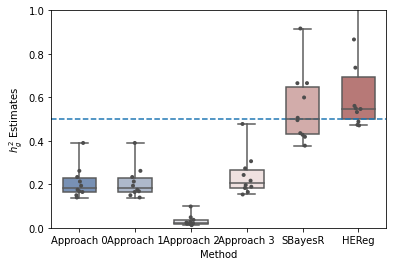

In [251]:
res_p5 = evaluate_heritability_w_simulations(0.5, 10)
plot_heritability_boxplot(res_p5, true_h2=0.5)

  0%|          | 0/5 [00:00<?, ?it/s]

Evaluating Heritability with Simulations...
Warning (Iteration 2): ELBO dropped from -685.746135 to -686.497140!
Max iterations reached without convergence. You may need to run the model for more iterations.


 20%|██        | 1/5 [14:32<58:10, 872.70s/it]

Warning (Iteration 2): ELBO dropped from -680.145389 to -681.732560!
Max iterations reached without convergence. You may need to run the model for more iterations.


 40%|████      | 2/5 [29:10<43:42, 874.21s/it]

Warning (Iteration 2): ELBO dropped from -682.992866 to -684.071308!
Max iterations reached without convergence. You may need to run the model for more iterations.


 60%|██████    | 3/5 [43:54<29:14, 877.31s/it]

Warning (Iteration 2): ELBO dropped from -683.445680 to -684.485534!
Max iterations reached without convergence. You may need to run the model for more iterations.


 80%|████████  | 4/5 [58:52<14:43, 883.45s/it]

Warning (Iteration 2): ELBO dropped from -682.012330 to -683.183330!
Max iterations reached without convergence. You may need to run the model for more iterations.


100%|██████████| 5/5 [1:14:10<00:00, 890.04s/it]


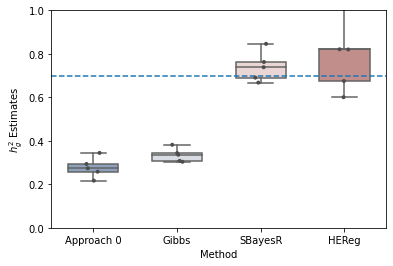

In [12]:
res_p7 = evaluate_heritability_w_simulations(0.7, 5)
plot_heritability_boxplot(res_p7, true_h2=0.7)

Max iterations reached without convergence. You may need to run the model for more iterations.


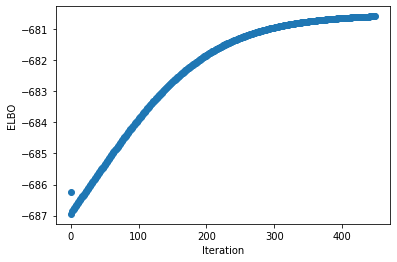

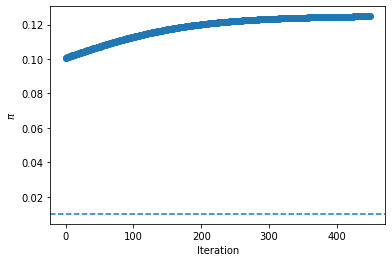

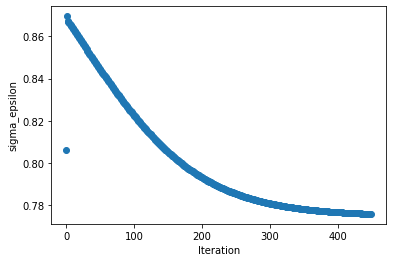

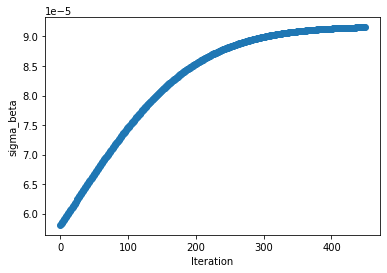

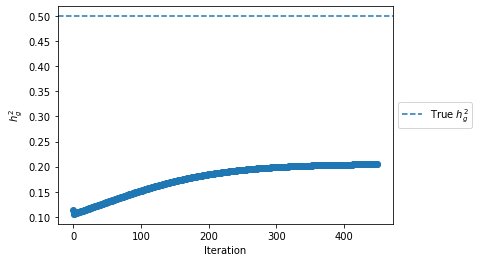

In [6]:
#vs = vem_prs_sbayes(gs)
vs.fit(max_iter=300, continued=True)
plot_history(vs)

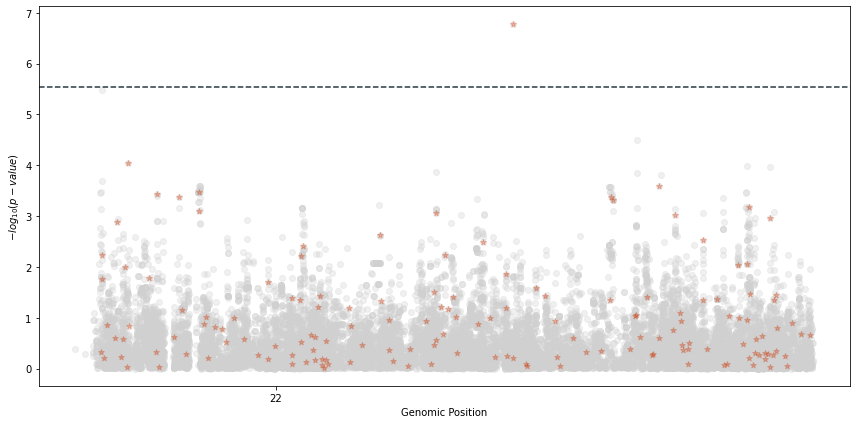

In [31]:
plot_manhattan(gs, hl_snps=gs.get_causal_status())

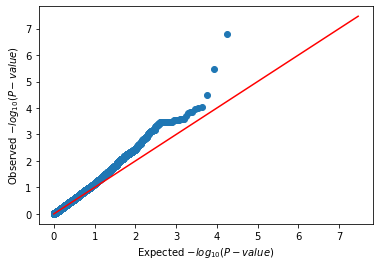

In [32]:
plot_qq(gs, quantity='p_value')

Max iterations reached without convergence. You may need to run the model for more iterations.


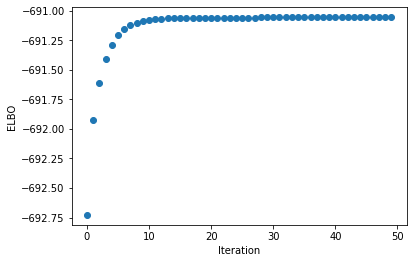

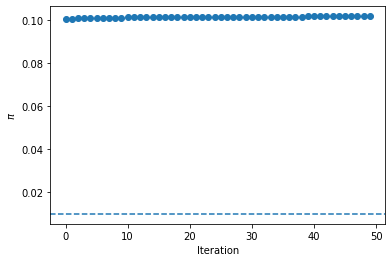

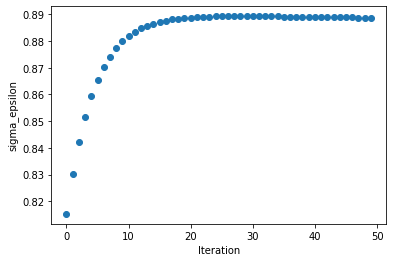

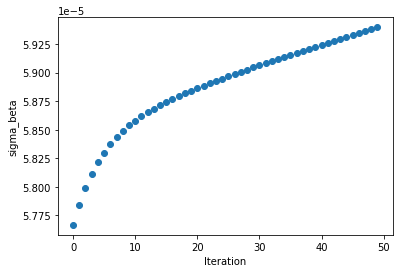

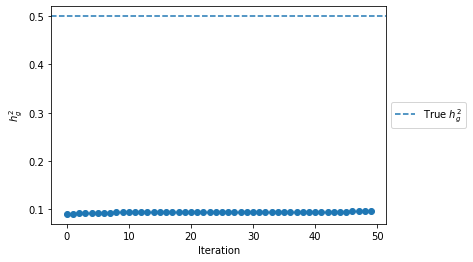

In [3]:
vc = vem_prs_cs(gs)
vc.fit(max_iter=50)
plot_history(vc)

Max iterations reached without convergence. You may need to run the model for more iterations.


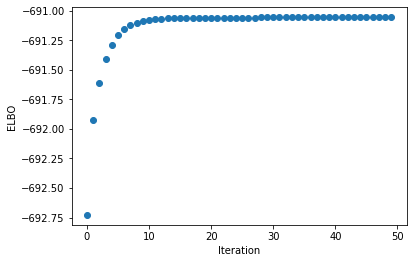

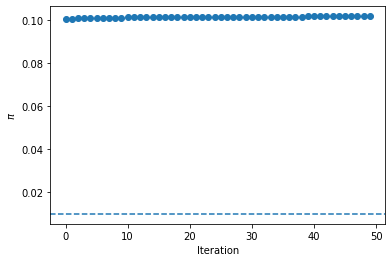

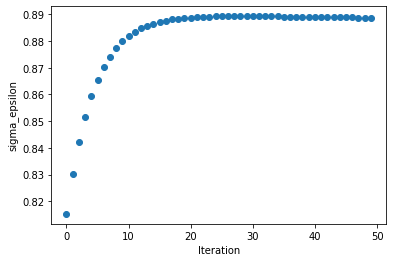

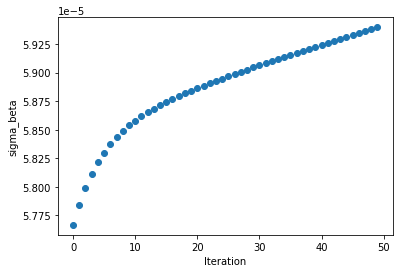

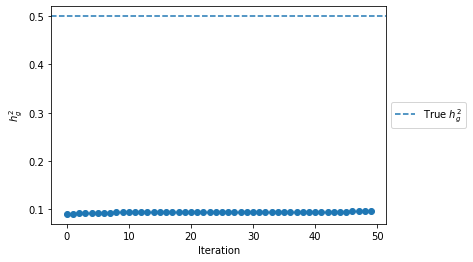

In [4]:
vc2 = vem_prs(gs, scale_prior=True)
vc2.fit(max_iter=50)
plot_history(vc2)

In [10]:
np.allclose(np.array(vc.history['ELBO']), np.array(vc2.history['ELBO']))

True

Max iterations reached without convergence. You may need to run the model for more iterations.


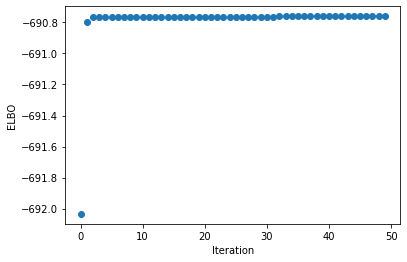

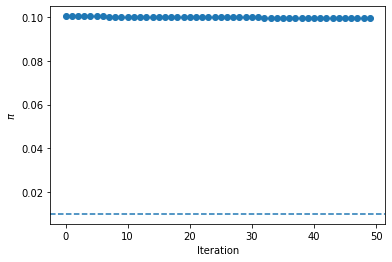

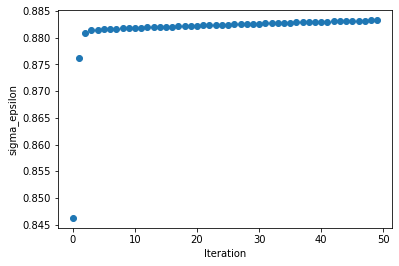

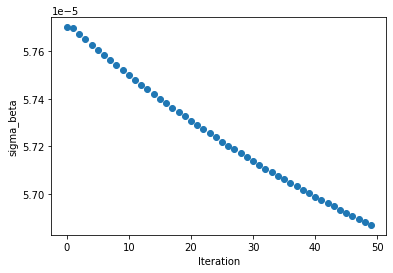

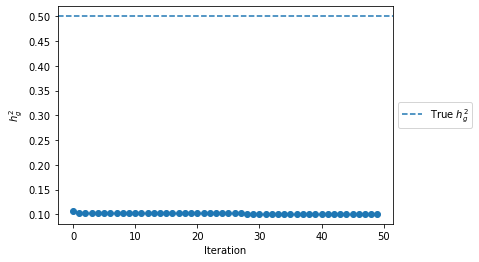

In [5]:
v = vem_prs(gs)
v.fit(max_iter=50)
plot_history(v)

In [19]:
gs.get_ld_matrices()[22]

<zarr.core.Array (17489, 17489) float32>

In [12]:
gs.get_ld_matrices()

Max iterations reached without convergence. You may need to run the model for more iterations.


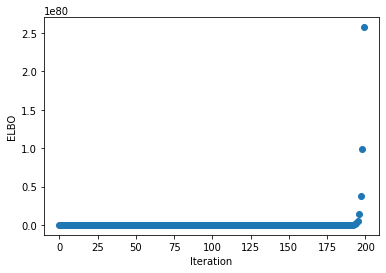

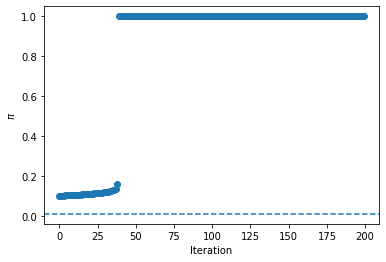

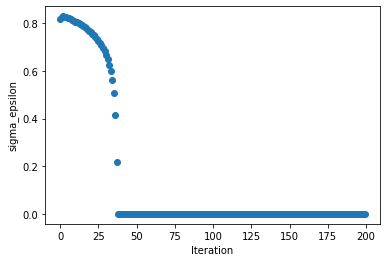

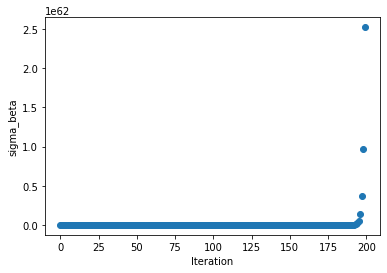

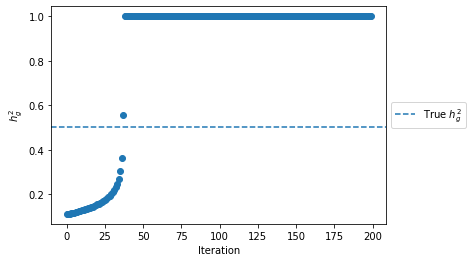

In [28]:
v = vem_prs(gs)
v.fit(max_iter=200)
plot_history(v)

100%|██████████| 400/400 [02:52<00:00,  2.32it/s]


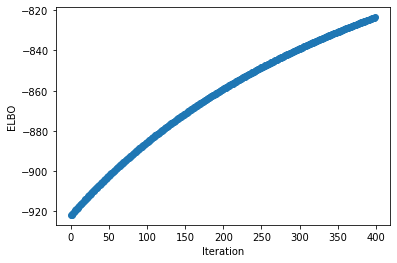

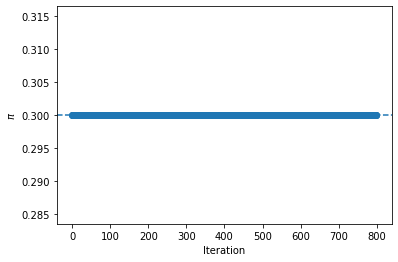

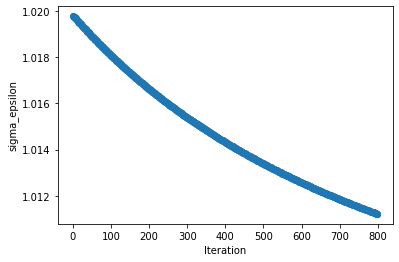

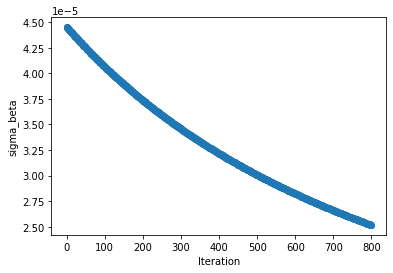

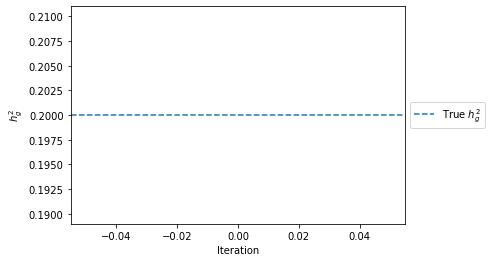

In [6]:
import copy

def fit_vem_prs(v, max_iter=100):
    
    v.initialize()
    elbo = []
    
    for i in tqdm(range(max_iter)):
        
        e_count = 0
        m_count = 0
        
        # E-Step:
        curr_mu_beta = copy.deepcopy(v.var_mu_beta[22])
        curr_gamma = copy.deepcopy(v.var_gamma[22])
        curr_sigma_beta = copy.deepcopy(v.var_sigma_beta[22])
        
        v.e_step()
        e_count += 1
        
        while not all([np.allclose(v.var_mu_beta[22], curr_mu_beta),
                       np.allclose(curr_gamma, v.var_gamma[22]),
                       np.allclose(curr_sigma_beta, v.var_sigma_beta[22])]):
            curr_mu_beta = copy.deepcopy(v.var_mu_beta[22])
            curr_gamma = copy.deepcopy(v.var_gamma[22])
            curr_sigma_beta = copy.deepcopy(v.var_sigma_beta[22])

            v.e_step()
            e_count += 1
        
        curr_pi = copy.deepcopy(v.pi)
        curr_sig_beta = copy.deepcopy(v.sigma_beta)
        curr_sig_epsilon = copy.deepcopy(v.sigma_epsilon)
        
        v.m_step()
        m_count += 1
        
        while not all([np.allclose(curr_pi, v.pi),
                       np.allclose(curr_sig_beta, v.sigma_beta),
                       np.allclose(curr_sig_epsilon, v.sigma_epsilon)]):
            curr_pi = copy.deepcopy(v.pi)
            curr_sig_beta = copy.deepcopy(v.sigma_beta)
            curr_sig_epsilon = copy.deepcopy(v.sigma_epsilon)

            v.m_step()
            m_count += 1
        
        elbo.append(v.objective())
        if len(elbo) > 1:
            if np.allclose(elbo[-1], elbo[-2], atol=1e-6):
                print("Converged!")
                break
        

v = vem_prs_cs(gs, fix_params={'pi': 0.3})
fit_vem_prs(v, max_iter=400)
plot_history(v)


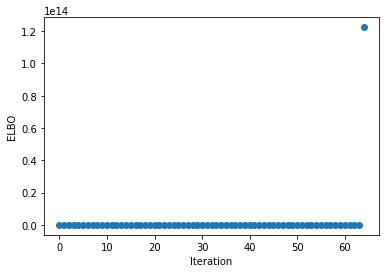

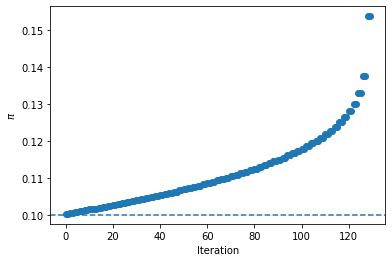

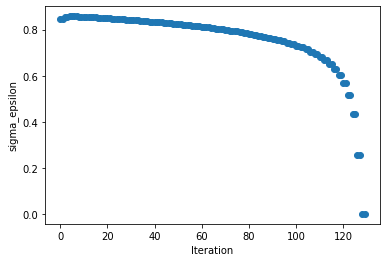

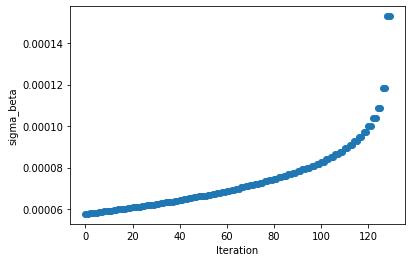

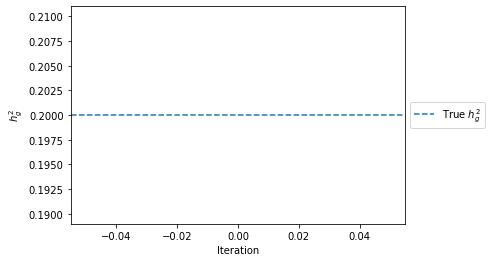

In [21]:
plot_history(v)

In [16]:
v.var_gamma[22]

array([0.09850298, 0.1079332 , 0.0991311 , ..., 0.09855312, 0.10002068,
       0.09977797])

In [7]:
v.var_gamma[22]

array([0.999999, 0.999999, 0.999999, ..., 0.999999, 0.999999, 0.999999])

In [5]:
gs2 = GWASSimulator("../data/1000G_EUR_Phase3_plink/1000G.EUR.QC.22.bed",
                   ld_store_files="temp/ld/chr_22/",
                   keep_snps="../data/w_snplist_no_MHC.snplist.bz2", #"../data/w_snplist_no_MHC.snplist.bz2", 
                   h2g=0.2)
gs2.simulate()
gs2.get_ld_matrices()

0it [00:00, ?it/s]

> Reading genotype files...


1it [00:03,  3.54s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

> Computing LD boundaries...


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


> Reading LD matrices...


{22: <zarr.core.Array (17489,) object>}

In [6]:
import zarr
gs2.ld[22] = zarr.open('temp/ld/chr_22/')

Max iterations reached without convergence. You may need to run the model for more iterations.


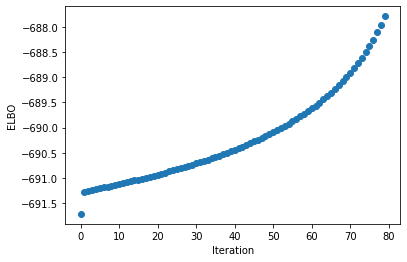

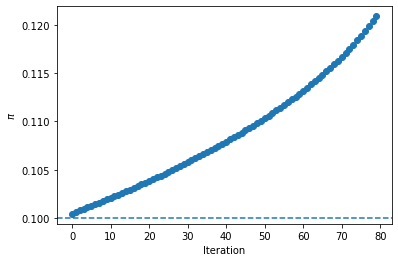

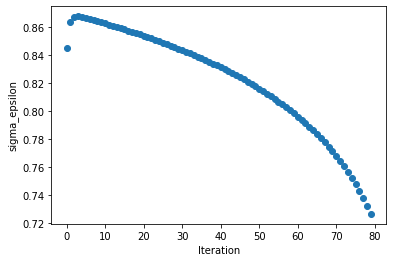

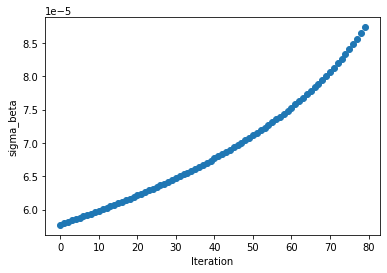

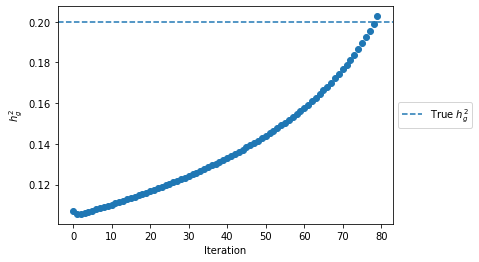

In [7]:
vss = vem_prs_ss(gs2)
vss.fit(max_iter=80)
plot_history(vss)

Max iterations reached without convergence. You may need to run the model for more iterations.


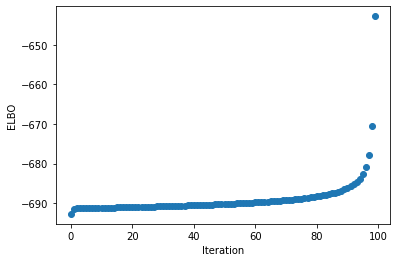

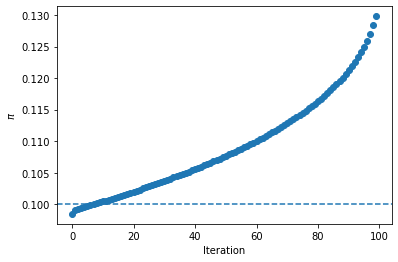

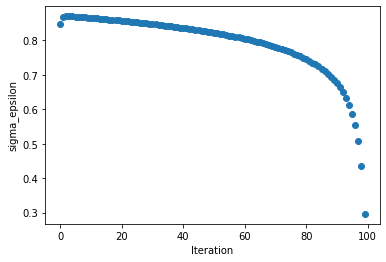

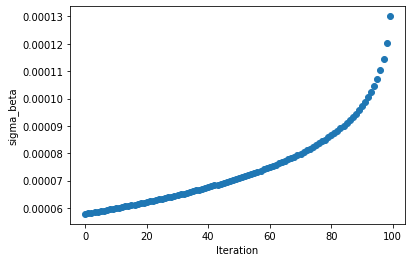

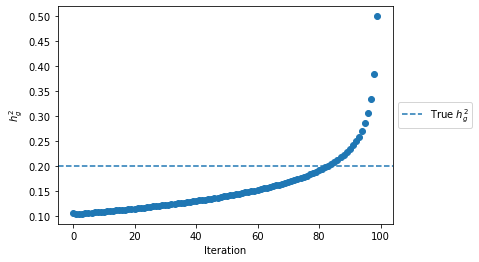

In [13]:
vss.fit(max_iter=100, vectorize=True)
plot_history(vss)

# Testing Models:

In [376]:
models = [TrueBetaPRS(gs), 
          PLINK_PT(gs), 
          MarginalBetaPRS(gs), 
          vem_prs_ss(gs), 
          SBayesR(gs,ldm="gctb_2.0_tutorial/ldm/sparse/chr22/1000G_eur_chr22.ldm.sparse"), 
          LASSOSum(gs)]
h2_models = [LDSCHeritability(gs, ref_ld_scores="data/1000G_EUR_Phase3_baseline/baseline",
                              w_ld_scores="data/1000G_Phase3_weights_hm3_no_MHC/weights.hm3_noMHC"), 
             HERegression(gs), 
             vem_prs_ss(gs), 
             SBayesR(gs, ldm="gctb_2.0_tutorial/ldm/sparse/chr22/1000G_eur_chr22.ldm.sparse")]

  0%|          | 0/5 [00:00<?, ?it/s]

Evaluating Heritability with Simulations...
Max iterations reached without convergence. You may need to run the model for more iterations.


 20%|██        | 1/5 [00:33<02:13, 33.32s/it]

Max iterations reached without convergence. You may need to run the model for more iterations.


 40%|████      | 2/5 [01:06<01:39, 33.33s/it]

Max iterations reached without convergence. You may need to run the model for more iterations.


 60%|██████    | 3/5 [01:41<01:07, 33.85s/it]

Max iterations reached without convergence. You may need to run the model for more iterations.


 80%|████████  | 4/5 [02:16<00:34, 34.23s/it]

Max iterations reached without convergence. You may need to run the model for more iterations.


100%|██████████| 5/5 [02:50<00:00, 34.06s/it]


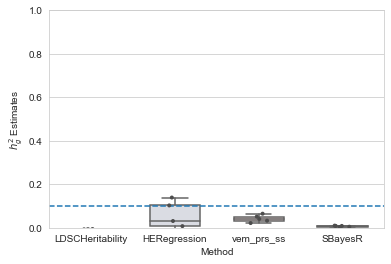

In [377]:
gs.h2g = 0.1
res = evaluate_heritability_w_simulations(h2_models, gs, n_traits=5)
plot_heritability_boxplot(res, true_h2=0.1)

  0%|          | 0/5 [00:00<?, ?it/s]

Evaluating Heritability with Simulations...
Converged at iteration 63 | ELBO: -657.0247006981389


 20%|██        | 1/5 [00:05<00:22,  5.72s/it]

Converged at iteration 26 | ELBO: -652.8106120246434


 40%|████      | 2/5 [00:09<00:15,  5.08s/it]

Converged at iteration 38 | ELBO: -673.8990295830297


 60%|██████    | 3/5 [00:13<00:09,  4.93s/it]

Converged at iteration 43 | ELBO: -646.6368282401116


 80%|████████  | 4/5 [00:18<00:04,  4.82s/it]

Converged at iteration 134 | ELBO: -654.2816754082332


100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


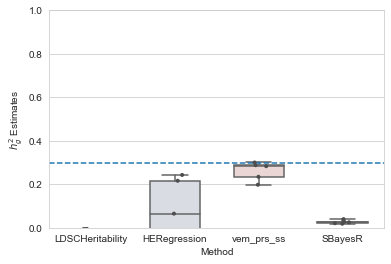

In [378]:
gs.h2g = 0.3
res = evaluate_heritability_w_simulations(h2_models, gs, n_traits=5)
plot_heritability_boxplot(res, true_h2=0.3)

In [379]:
gs.h2g = 0.5
res = evaluate_heritability_w_simulations(h2_models, gs, n_traits=5)
plot_heritability_boxplot(res, true_h2=0.5)

  0%|          | 0/5 [00:00<?, ?it/s]

Evaluating Heritability with Simulations...
Converged at iteration 94 | ELBO: -586.5806637227972


  0%|          | 0/5 [00:07<?, ?it/s]


CalledProcessError: Command '
            gctb_2.0/gctb --sbayes R                  --ldm gctb_2.0_tutorial/ldm/sparse/chr22/1000G_eur_chr22.ldm.sparse                  --pi 0.95,0.02,0.02,0.01                  --gamma 0.0,0.01,0.1,1                  --gwas-summary temp/sbayesr/Simulated_102.ma                  --chain-length 10000                  --burn-in 2000                  --out-freq 100                  --out temp/sbayesr/Simulated_102
        ' returned non-zero exit status 0.

# LDPred Simulated Datasets

0it [00:00, ?it/s]

> Reading genotype files...


1it [00:01,  1.16s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

> Computing LD boundaries...
> Computing LD matrices...


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Converged at iteration 30 | ELBO: -10873.210167


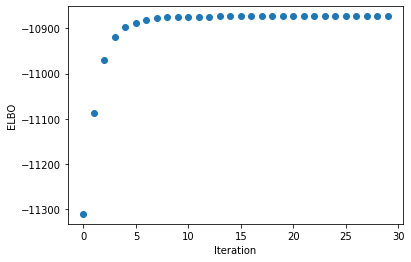

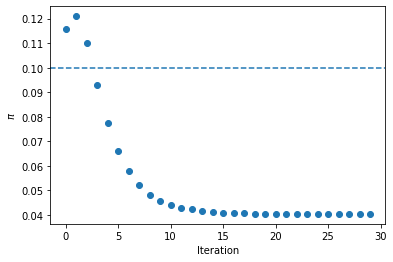

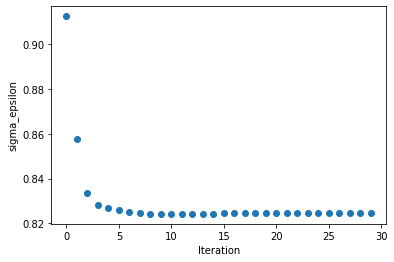

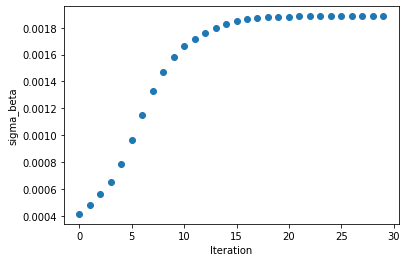

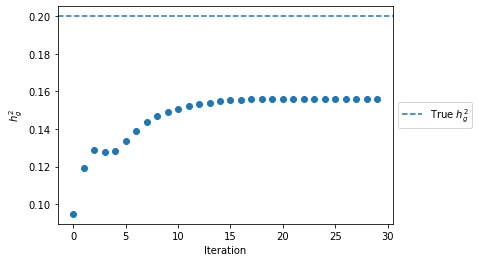

In [59]:
ldp_gs1 = GWASSimulator("ldpred/tests/test_data/sim1_0_train",
                        shrink_ld=False, temp_dir='temp/LDPredData/sim_1/')
ldp_gs1.simulate()
vc = vem_prs(ldp_gs1)
vc.fit(max_iter=200)
plot_history(vc)

Max iterations reached without convergence. You may need to run the model for more iterations.


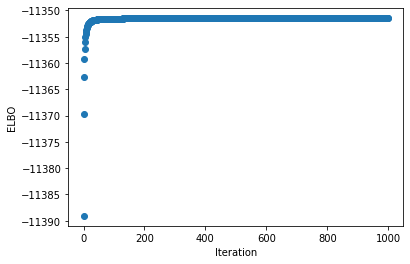

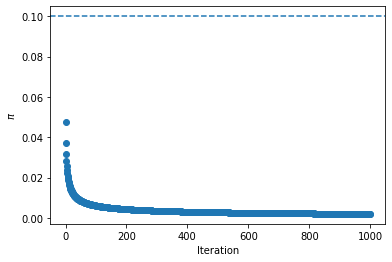

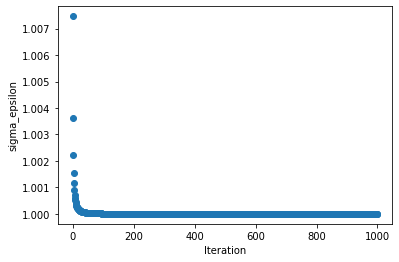

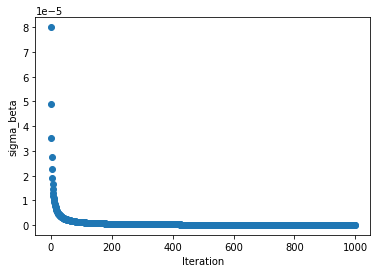

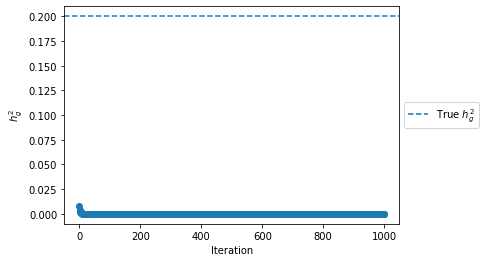

In [3]:
v = vem_prs_cs(ldp_gs1)
v.fit(max_iter=1000)
plot_history(v)

In [4]:
v.history['ELBO']

[-11389.075285204228,
 -11369.765433659744,
 -11362.724705500668,
 -11359.274085951332,
 -11357.288752207009,
 -11356.025102450578,
 -11355.162835867286,
 -11354.54372034829,
 -11354.08155511706,
 -11353.72579571585,
 -11353.445052918754,
 -11353.218912693432,
 -11353.033585697705,
 -11352.879457238003,
 -11352.749640339844,
 -11352.639086232759,
 -11352.544018388944,
 -11352.461561541122,
 -11352.389492087454,
 -11352.32606625808,
 -11352.269899371964,
 -11352.21987942556,
 -11352.175104223144,
 -11352.134834946966,
 -11352.098461399355,
 -11352.065475657582,
 -11352.03545187652,
 -11352.008030641304,
 -11351.98290672701,
 -11351.959819437132,
 -11351.938544913794,
 -11351.918889969462,
 -11351.900687103145,
 -11351.88379044616,
 -11351.868072443005,
 -11351.853421117718,
 -11351.83973780972,
 -11351.82693528851,
 -11351.814936175877,
 -11351.803671619225,
 -11351.793080170926,
 -11351.783106837753,
 -11351.773702271146,
 -11351.764822074922,
 -11351.756426211101,
 -11351.748478488174

0it [00:00, ?it/s]

> Reading genotype files...


1it [00:01,  1.32s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

> Computing LD boundaries...
> Computing LD matrices...


100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Max iterations reached without convergence. You may need to run the model for more iterations.


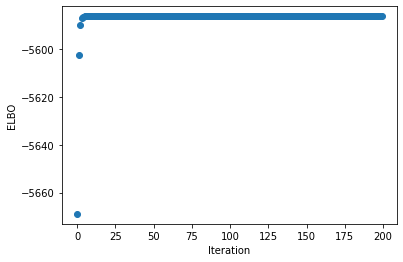

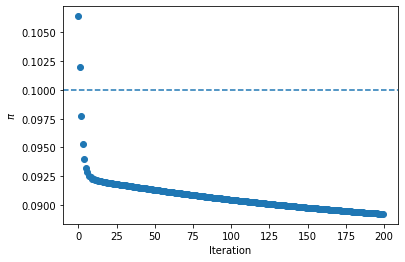

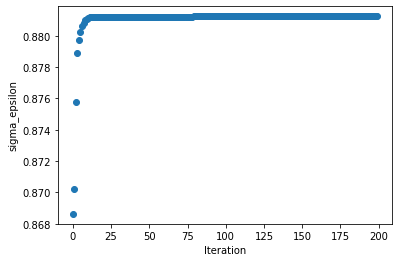

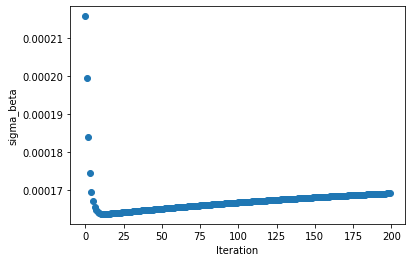

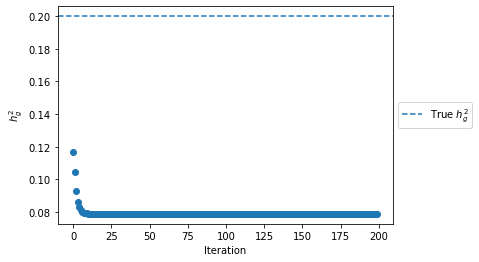

In [27]:
ldp_gs2 = GWASSimulator("ldpred/tests/test_data/sim2_0_train",
                        shrink_ld=False, temp_dir='temp/LDPredData/sim_2/')
ldp_gs2.simulate()
vc = vem_prs(ldp_gs2)
vc.fit(max_iter=200)
plot_history(vc)

0it [00:00, ?it/s]

> Reading genotype files...


1it [00:03,  3.24s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

> Computing LD boundaries...
> Computing LD matrices...


100%|██████████| 1/1 [00:18<00:00, 18.84s/it]


Converged at iteration 85 | ELBO: -11073.203577


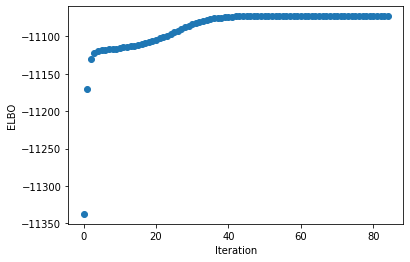

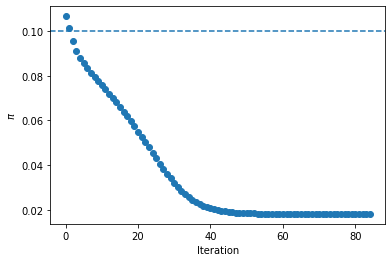

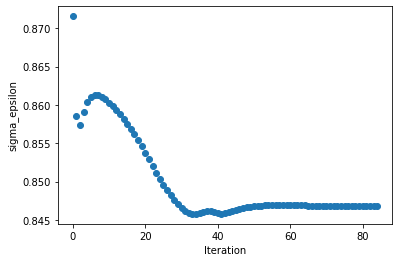

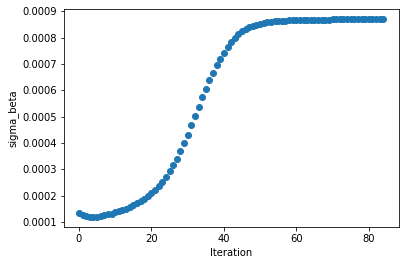

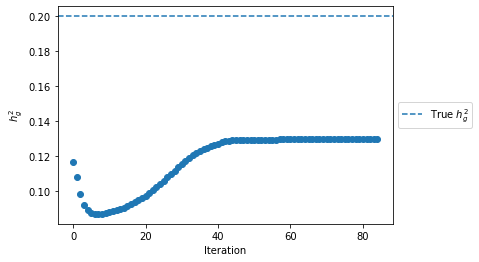

In [28]:
ldp_gs3 = GWASSimulator("ldpred/tests/test_data/sim3_0_train",
                        shrink_ld=False, temp_dir='temp/LDPredData/sim_3/')
ldp_gs3.simulate()
vc = vem_prs(ldp_gs3)
vc.fit(max_iter=200)
plot_history(vc)

0it [00:00, ?it/s]

> Reading genotype files...


1it [00:02,  2.96s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

> Computing LD boundaries...
> Computing LD matrices...


100%|██████████| 1/1 [00:19<00:00, 19.89s/it]


Converged at iteration 195 | ELBO: -11160.136841


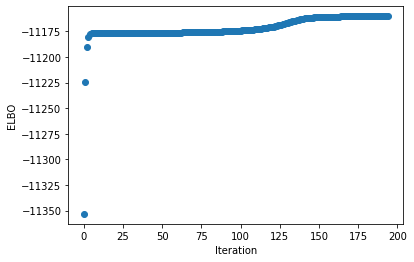

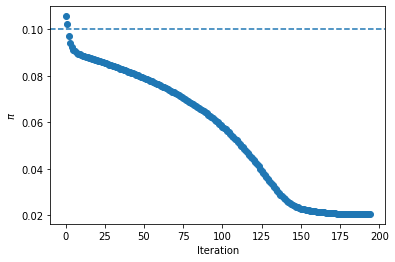

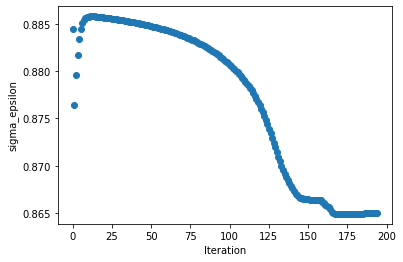

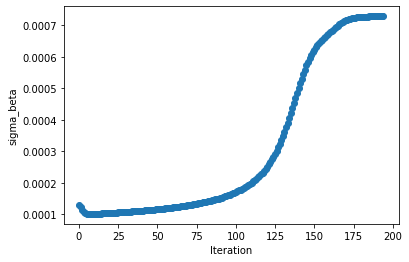

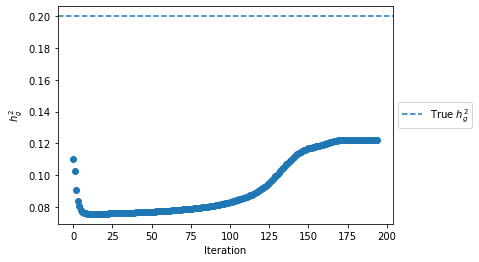

In [29]:
ldp_gs4 = GWASSimulator("ldpred/tests/test_data/sim4_0_train",
                        shrink_ld=False, temp_dir='temp/LDPredData/sim_4/')
ldp_gs4.simulate()
vc = vem_prs(ldp_gs4)
vc.fit(max_iter=200)
plot_history(vc)

0it [00:00, ?it/s]

> Reading genotype files...


1it [00:02,  2.95s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

> Computing LD boundaries...
> Computing LD matrices...


100%|██████████| 1/1 [00:16<00:00, 16.85s/it]


Max iterations reached without convergence. You may need to run the model for more iterations.


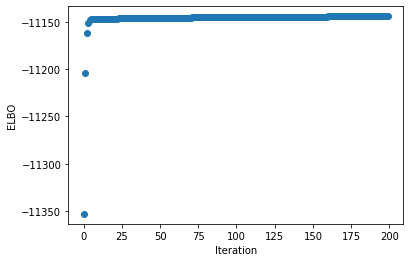

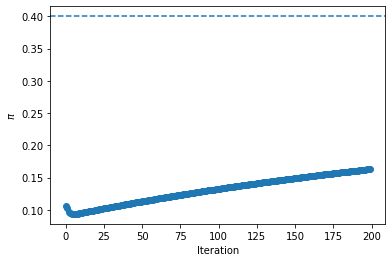

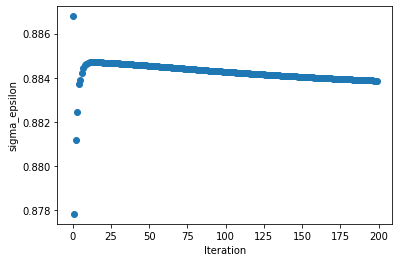

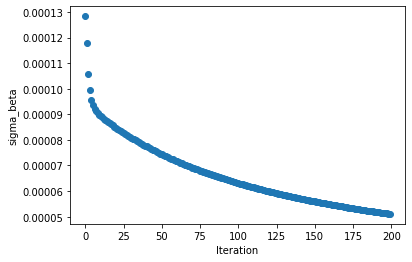

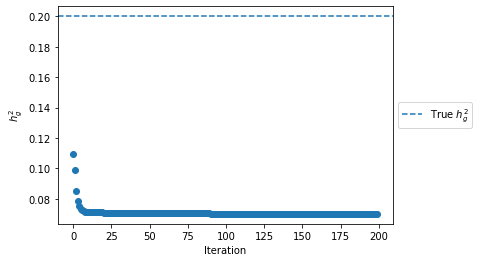

In [32]:
ldp_gs5 = GWASSimulator("ldpred/tests/test_data/sim5_0_train",
                        shrink_ld=False, temp_dir='temp/LDPredData/sim_5/')
ldp_gs5.pis = (0.6, 0.4)
ldp_gs5.simulate(reset_beta=True)
vc = vem_prs(ldp_gs5)
vc.fit(max_iter=200)
plot_history(vc)

# Testing Heritability Estimation

In [2]:
ldp_gs = GWASSimulator("ldpred/tests/test_data/sim1_0_train",
                        shrink_ld=False, temp_dir='temp/LDPredData/sim_1/')
ldp_gs.simulate()

0it [00:00, ?it/s]

> Reading genotype files...


1it [00:00,  1.42it/s]


In [3]:
vc = vem_prs(ldp_gs)
vc.beta_hat, ldp_gs.beta_hats

  0%|          | 0/1 [00:00<?, ?it/s]

> Computing LD boundaries...
> Computing LD matrices...


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


({1: SNP_ID_1_1       0.016715
  SNP_ID_1_2       0.013809
  SNP_ID_1_3       0.014118
  SNP_ID_1_4       0.017505
  SNP_ID_1_5       0.007523
                     ...   
  SNP_ID_1_1996   -0.071663
  SNP_ID_1_1997   -0.080252
  SNP_ID_1_1998   -0.072806
  SNP_ID_1_1999   -0.059991
  SNP_ID_1_2000   -0.067868
  Length: 2000, dtype: float64},
 {1: SNP_ID_1_1       0.016715
  SNP_ID_1_2       0.013809
  SNP_ID_1_3       0.014118
  SNP_ID_1_4       0.017505
  SNP_ID_1_5       0.007523
                     ...   
  SNP_ID_1_1996   -0.071663
  SNP_ID_1_1997   -0.080252
  SNP_ID_1_1998   -0.072806
  SNP_ID_1_1999   -0.059991
  SNP_ID_1_2000   -0.067868
  Length: 2000, dtype: float64})

In [4]:
ldp_gs.simulate()
vc.beta_hat, ldp_gs.beta_hats

({1: SNP_ID_1_1       0.016715
  SNP_ID_1_2       0.013809
  SNP_ID_1_3       0.014118
  SNP_ID_1_4       0.017505
  SNP_ID_1_5       0.007523
                     ...   
  SNP_ID_1_1996   -0.071663
  SNP_ID_1_1997   -0.080252
  SNP_ID_1_1998   -0.072806
  SNP_ID_1_1999   -0.059991
  SNP_ID_1_2000   -0.067868
  Length: 2000, dtype: float64},
 {1: SNP_ID_1_1       0.004712
  SNP_ID_1_2      -0.000175
  SNP_ID_1_3       0.000316
  SNP_ID_1_4       0.017160
  SNP_ID_1_5       0.008190
                     ...   
  SNP_ID_1_1996   -0.050744
  SNP_ID_1_1997   -0.054398
  SNP_ID_1_1998   -0.051026
  SNP_ID_1_1999   -0.045764
  SNP_ID_1_2000   -0.059546
  Length: 2000, dtype: float64})

In [5]:
vc.initialize()
vc.beta_hat, ldp_gs.beta_hats

({1: SNP_ID_1_1       0.004712
  SNP_ID_1_2      -0.000175
  SNP_ID_1_3       0.000316
  SNP_ID_1_4       0.017160
  SNP_ID_1_5       0.008190
                     ...   
  SNP_ID_1_1996   -0.050744
  SNP_ID_1_1997   -0.054398
  SNP_ID_1_1998   -0.051026
  SNP_ID_1_1999   -0.045764
  SNP_ID_1_2000   -0.059546
  Length: 2000, dtype: float64},
 {1: SNP_ID_1_1       0.004712
  SNP_ID_1_2      -0.000175
  SNP_ID_1_3       0.000316
  SNP_ID_1_4       0.017160
  SNP_ID_1_5       0.008190
                     ...   
  SNP_ID_1_1996   -0.050744
  SNP_ID_1_1997   -0.054398
  SNP_ID_1_1998   -0.051026
  SNP_ID_1_1999   -0.045764
  SNP_ID_1_2000   -0.059546
  Length: 2000, dtype: float64})

Converged at iteration 126 | ELBO: -10823.815556829304


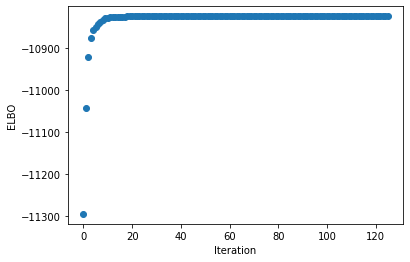

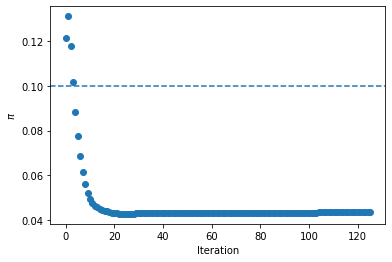

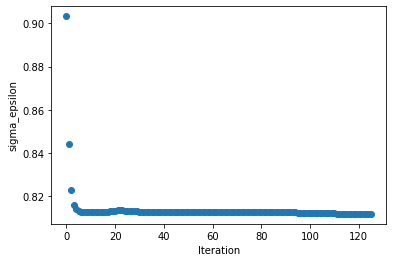

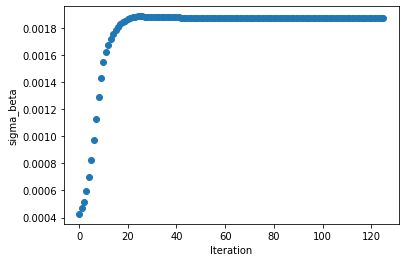

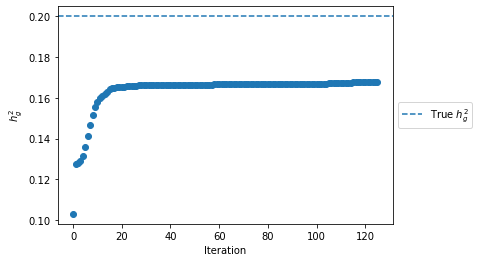

In [5]:
vp.fit()
plot_history(vp)

Converged at iteration 126 | ELBO: -10823.815557


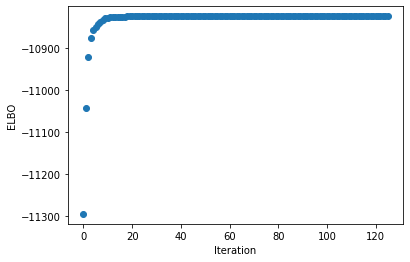

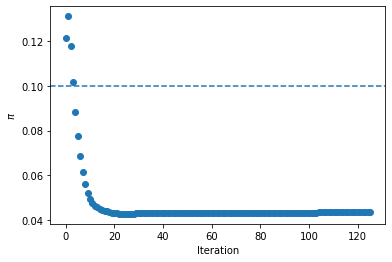

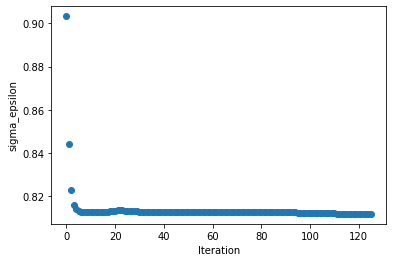

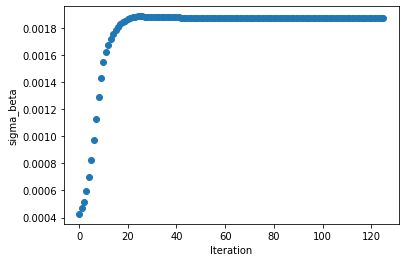

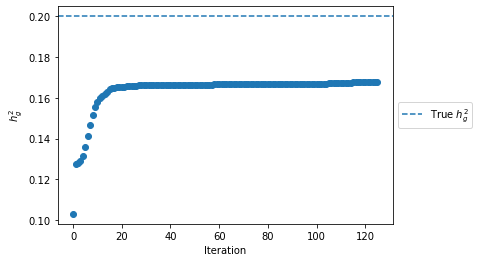

In [6]:
vc.fit()
plot_history(vc)

In [10]:
import copy
mu_beta = np.random.normal(size=len(vp.var_mu_beta[1]))
sig_beta = np.random.uniform(size=len(vp.var_mu_beta[1]))
gamma = np.random.uniform(size=len(vp.var_mu_beta[1]))

vp.var_mu_beta[1] = copy.deepcopy(mu_beta)
vc.var_mu_beta[1] = copy.deepcopy(mu_beta)
vp.var_sigma_beta[1] = copy.deepcopy(sig_beta)
vc.var_sigma_beta[1] = copy.deepcopy(sig_beta)
vp.var_gamma[1] = copy.deepcopy(gamma)
vc.var_gamma[1] = copy.deepcopy(gamma)

vp.pi = 0.1
vc.pi = 0.1
vp.sigma_beta = 0.001
vc.sigma_beta = 0.001
vp.sigma_epsilon = 0.8
vc.sigma_epsilon = 0.8

In [13]:
vp.m_step(), vc.m_step()

(None, None)

In [6]:
vp.get_heritability(), vc.get_heritability()

(0.9994827841752008, 0.9994827841752008)

In [14]:
vp.objective(), vc.objective()

(-44899.401010024456, -44899.394090727226)

In [14]:
vc.m_step()
vc.ld_prod

78.07601937674485

In [15]:
gamma_mu = vp.var_gamma[1]*vp.var_mu_beta[1]
2.*np.dot(gamma_mu, vp.R_triu[1].dot(gamma_mu))

78.07601937674531

In [21]:
check_allclose_e(), check_allclose_m()

((True, True, True), (False, False, False))

In [7]:
(vp.pi, vc.pi), (vp.sigma_beta, vc.sigma_beta), (vp.sigma_epsilon, vc.sigma_epsilon)

((0.1, 0.1), (0.001, 0.001), (0.8, 0.8))

In [12]:
vc.var_mu_beta[1], vp.var_mu_beta[1]

(array([ 0.92037795,  0.56528039, -0.07319743, ...,  0.73272568,
        -0.87389891, -0.22158422]),
 array([-1.4139931 ,  0.08069414, -0.20305094, ...,  0.64237114,
        -0.52489908, -0.2380028 ]))

In [11]:
print(check_allclose_e(), check_allclose_m())
vc.e_step()
vp.e_step_loop()
vc.m_step()
vp.m_step()
check_allclose_e(), check_allclose_m(), vp.objective(), vc.objective()

(True, True, True) (True, True, True)


((False, True, False),
 (False, False, False),
 -41440.03758213648,
 -43617.686495064525)

In [10]:
def check_allclose_e():
    return np.allclose(vp.var_mu_beta[1], vc.var_mu_beta[1]), np.allclose(vp.var_sigma_beta[1], vc.var_sigma_beta[1]), np.allclose(vp.var_gamma[1], vc.var_gamma[1])

def check_allclose_m():
    return np.allclose(vp.pi, vc.pi), np.allclose(vp.sigma_beta, vc.sigma_beta), np.allclose(vp.sigma_epsilon, vc.sigma_epsilon)

In [25]:
print(check_allclose_e(), check_allclose_m())
vp.e_step_loop(), vc.e_step()
print(check_allclose_e(), check_allclose_m())

(False, True, True) (True, True, True)
(False, True, True) (True, True, True)


In [26]:
print(check_allclose_e(), check_allclose_m())
vp.m_step(), vc.m_step()
print(check_allclose_e(), check_allclose_m())

(False, True, True) (True, True, True)
(False, True, True) (True, True, True)


In [28]:
vp.var_mu_beta[1], vc.var_mu_beta[1]

(array([-0.1673912 , -0.12924021, -0.08966061, ..., -0.01969038,
         0.02635708,  0.03157538]),
 array([-0.16739094, -0.12923999, -0.08966045, ..., -0.01969061,
         0.02635672,  0.03157535]))

In [12]:
np.allclose(vp.R_zero_diag[1][200], vc.ld[1][200])

False

In [29]:
var_prod = np.multiply(vc.var_gamma[1], vc.var_mu_beta[1])
ld_bound = vc.ld_bounds[1]
Di = vc.ld[1][200]
np.dot(Di, var_prod[ld_bound[0, 200]: ld_bound[1, 200]]) - Di[200 - ld_bound[0, 200]]*var_prod[200]

0.7512932934606795

In [24]:
var_prod[200], (vp.var_gamma[1]*vp.var_mu_beta[1])[200]

(1.2004102550380358, 1.2004102550380358)

In [19]:
vp.R_zero_diag[1][200, :].dot(vp.var_gamma[1]*vp.var_mu_beta[1])

0.7512932934607771

In [20]:
ldp_gs.ld[1][200, :].dot(vp.var_gamma[1]*vp.var_mu_beta[1])

1.9517035484988132

In [35]:
vp.fit(), vc.fit()

Converged at iteration 31 | ELBO: -9271.320519561268
Converged at iteration 40 | ELBO: -9285.741304


(<vem.vem_prs_ss at 0x7f846c6b1fa0>, <vem_c.vem_prs at 0x7f8435fa5650>)

In [36]:
vp.get_heritability(), vc.get_heritability()

(0.46110688421821217, 0.4504841722625601)

In [37]:
vp.var_mu_beta[1], vc.var_mu_beta[1]

(array([-0.00825681, -0.01193223, -0.00280466, ...,  0.00221281,
         0.00634235,  0.01302149]),
 array([-0.00769133, -0.01302343, -0.00280742, ...,  0.00246413,
         0.00743471,  0.01503045]))

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating Heritability with Simulations...
Converged at iteration 42 | ELBO: -11188.865886142288
Converged at iteration 42 | ELBO: -11188.865886


 10%|█         | 1/10 [00:12<01:52, 12.55s/it]

Converged at iteration 40 | ELBO: -11224.671398889792
Converged at iteration 40 | ELBO: -11224.671399


 20%|██        | 2/10 [00:25<01:40, 12.57s/it]

Converged at iteration 36 | ELBO: -11193.20228692918
Converged at iteration 36 | ELBO: -11193.202287


 30%|███       | 3/10 [00:36<01:25, 12.16s/it]

Converged at iteration 92 | ELBO: -11208.348117506343
Converged at iteration 92 | ELBO: -11208.348118


 40%|████      | 4/10 [00:54<01:23, 13.94s/it]

Converged at iteration 40 | ELBO: -11224.638635172632
Converged at iteration 40 | ELBO: -11224.638635


 50%|█████     | 5/10 [01:06<01:06, 13.31s/it]

Converged at iteration 47 | ELBO: -11204.365669765139
Converged at iteration 47 | ELBO: -11204.365670


 60%|██████    | 6/10 [01:18<00:51, 13.00s/it]

Converged at iteration 35 | ELBO: -11183.534933580268
Converged at iteration 35 | ELBO: -11183.534934


 70%|███████   | 7/10 [01:29<00:37, 12.40s/it]

Converged at iteration 33 | ELBO: -11176.125319468654
Converged at iteration 33 | ELBO: -11176.125319


 80%|████████  | 8/10 [01:40<00:23, 11.89s/it]

Converged at iteration 41 | ELBO: -11222.721712577397
Converged at iteration 41 | ELBO: -11222.721713


 90%|█████████ | 9/10 [01:52<00:11, 11.86s/it]

Converged at iteration 43 | ELBO: -11201.725556845431
Converged at iteration 43 | ELBO: -11201.725557


100%|██████████| 10/10 [02:03<00:00, 12.37s/it]


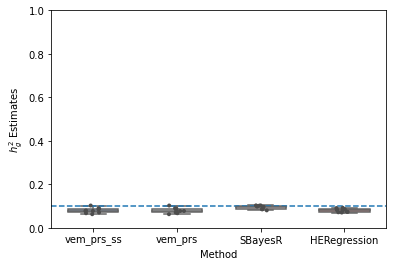

In [7]:
ldp_gs.h2g = 0.1
res = evaluate_heritability_w_simulations([vem_prs_ss(ldp_gs), vem_prs(ldp_gs), SBayesR(ldp_gs), HERegression(ldp_gs)], ldp_gs, n_traits=10)
plot_heritability_boxplot(res, true_h2=0.1)

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating Heritability with Simulations...
Converged at iteration 48 | ELBO: -10502.16041554322
Converged at iteration 48 | ELBO: -10502.160416


 10%|█         | 1/10 [00:13<02:02, 13.59s/it]

Converged at iteration 60 | ELBO: -10586.158366469506
Converged at iteration 60 | ELBO: -10586.158366


 20%|██        | 2/10 [00:29<01:53, 14.19s/it]

Converged at iteration 35 | ELBO: -10550.217809032336
Converged at iteration 35 | ELBO: -10550.217809


 30%|███       | 3/10 [00:40<01:34, 13.45s/it]

Converged at iteration 32 | ELBO: -10573.92014216944
Converged at iteration 32 | ELBO: -10573.920142


 40%|████      | 4/10 [00:51<01:16, 12.73s/it]

Converged at iteration 56 | ELBO: -10429.598184898314
Converged at iteration 56 | ELBO: -10429.598185


 50%|█████     | 5/10 [01:06<01:06, 13.34s/it]

Converged at iteration 53 | ELBO: -10549.728819147402
Converged at iteration 53 | ELBO: -10549.728819


 60%|██████    | 6/10 [01:20<00:53, 13.39s/it]

Converged at iteration 41 | ELBO: -10449.1545433561
Converged at iteration 41 | ELBO: -10449.154543


 70%|███████   | 7/10 [01:32<00:38, 12.92s/it]

Converged at iteration 57 | ELBO: -10507.70019655567
Converged at iteration 57 | ELBO: -10507.700197


 80%|████████  | 8/10 [01:46<00:26, 13.32s/it]

Converged at iteration 140 | ELBO: -10485.379096152628
Converged at iteration 140 | ELBO: -10485.379096


 90%|█████████ | 9/10 [02:11<00:16, 16.81s/it]

Converged at iteration 54 | ELBO: -10517.593577978208
Converged at iteration 54 | ELBO: -10517.593578


100%|██████████| 10/10 [02:25<00:00, 14.54s/it]


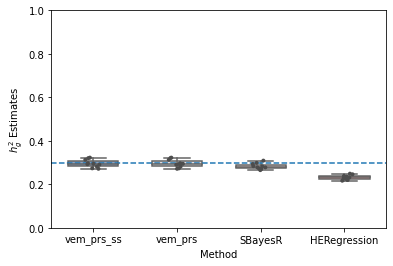

In [8]:
ldp_gs.h2g = 0.3
res = evaluate_heritability_w_simulations([vem_prs_ss(ldp_gs), vem_prs(ldp_gs), SBayesR(ldp_gs), HERegression(ldp_gs)], ldp_gs, n_traits=10)
plot_heritability_boxplot(res, true_h2=0.3)

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating Heritability with Simulations...
Converged at iteration 71 | ELBO: -9263.970882840453
Converged at iteration 71 | ELBO: -9263.970883


 10%|█         | 1/10 [00:15<02:23, 15.98s/it]

Converged at iteration 55 | ELBO: -9339.967285742357
Converged at iteration 55 | ELBO: -9339.967286


 20%|██        | 2/10 [00:29<02:01, 15.16s/it]

Converged at iteration 48 | ELBO: -9307.53543552558
Converged at iteration 48 | ELBO: -9307.535436


 30%|███       | 3/10 [00:41<01:40, 14.39s/it]

Converged at iteration 135 | ELBO: -9289.560369178716
Converged at iteration 135 | ELBO: -9289.560369


 40%|████      | 4/10 [01:05<01:43, 17.22s/it]

Converged at iteration 62 | ELBO: -9287.456946625705
Converged at iteration 62 | ELBO: -9287.456947


 50%|█████     | 5/10 [01:20<01:22, 16.50s/it]

Converged at iteration 64 | ELBO: -9322.844937375772
Converged at iteration 64 | ELBO: -9322.844937


 60%|██████    | 6/10 [01:35<01:03, 15.98s/it]

Converged at iteration 36 | ELBO: -9223.889860645733
Converged at iteration 36 | ELBO: -9223.889861


 70%|███████   | 7/10 [01:46<00:43, 14.51s/it]

Converged at iteration 24 | ELBO: -9268.461720180818
Converged at iteration 24 | ELBO: -9268.461720


 80%|████████  | 8/10 [01:55<00:25, 12.96s/it]

Converged at iteration 77 | ELBO: -9241.931633477529
Converged at iteration 77 | ELBO: -9241.931633


 90%|█████████ | 9/10 [02:11<00:13, 13.92s/it]

Converged at iteration 24 | ELBO: -9285.661590458822
Converged at iteration 24 | ELBO: -9285.661590


100%|██████████| 10/10 [02:21<00:00, 14.16s/it]


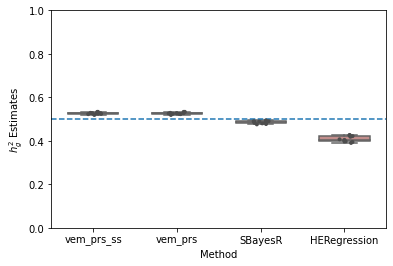

In [9]:
ldp_gs.h2g = 0.5
res = evaluate_heritability_w_simulations([vem_prs_ss(ldp_gs), vem_prs(ldp_gs), SBayesR(ldp_gs), HERegression(ldp_gs)], ldp_gs, n_traits=10)
plot_heritability_boxplot(res, true_h2=0.5)

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating Heritability with Simulations...
Converged at iteration 58 | ELBO: -7426.228402601264
Converged at iteration 58 | ELBO: -7426.228403


 10%|█         | 1/10 [00:13<02:00, 13.43s/it]

Converged at iteration 36 | ELBO: -7459.9419665969535
Converged at iteration 36 | ELBO: -7459.941967


 20%|██        | 2/10 [00:24<01:41, 12.67s/it]

Converged at iteration 42 | ELBO: -7388.632000796412
Converged at iteration 42 | ELBO: -7388.632001


 30%|███       | 3/10 [00:36<01:27, 12.46s/it]

Converged at iteration 58 | ELBO: -7492.216820397685
Converged at iteration 58 | ELBO: -7492.216820


 40%|████      | 4/10 [00:49<01:16, 12.72s/it]

Converged at iteration 89 | ELBO: -7501.660337722814
Converged at iteration 89 | ELBO: -7501.660338


 50%|█████     | 5/10 [01:07<01:11, 14.24s/it]

Converged at iteration 63 | ELBO: -7440.311278629059
Converged at iteration 63 | ELBO: -7440.311279


 60%|██████    | 6/10 [01:21<00:57, 14.33s/it]

Converged at iteration 55 | ELBO: -7472.382052356446
Converged at iteration 55 | ELBO: -7472.382052


 70%|███████   | 7/10 [01:36<00:42, 14.31s/it]

Converged at iteration 40 | ELBO: -7469.792356828117
Converged at iteration 40 | ELBO: -7469.792357


 80%|████████  | 8/10 [01:48<00:27, 13.60s/it]

Converged at iteration 33 | ELBO: -7469.995344700725
Converged at iteration 33 | ELBO: -7469.995345


 90%|█████████ | 9/10 [01:59<00:12, 12.80s/it]

Converged at iteration 35 | ELBO: -7440.196514372257
Converged at iteration 35 | ELBO: -7440.196514


100%|██████████| 10/10 [02:09<00:00, 12.95s/it]


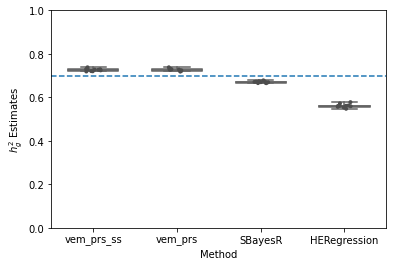

In [10]:
ldp_gs.h2g = 0.7
res = evaluate_heritability_w_simulations([vem_prs_ss(ldp_gs), vem_prs(ldp_gs), SBayesR(ldp_gs), HERegression(ldp_gs)], ldp_gs, n_traits=10)
plot_heritability_boxplot(res, true_h2=0.7)

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating Heritability with Simulations...
Converged at iteration 79 | ELBO: -3195.646805222238
Converged at iteration 79 | ELBO: -3195.646805


 10%|█         | 1/10 [00:17<02:34, 17.15s/it]

Converged at iteration 35 | ELBO: -3295.024883093609
Converged at iteration 35 | ELBO: -3295.024883


 20%|██        | 2/10 [00:28<02:02, 15.35s/it]

Converged at iteration 42 | ELBO: -3304.00987116768
Converged at iteration 42 | ELBO: -3304.009871


 30%|███       | 3/10 [00:40<01:40, 14.34s/it]

Converged at iteration 57 | ELBO: -3229.498078390965
Converged at iteration 57 | ELBO: -3229.498078


 40%|████      | 4/10 [00:54<01:25, 14.17s/it]

Converged at iteration 33 | ELBO: -3240.3146452610777
Converged at iteration 33 | ELBO: -3240.314645


 50%|█████     | 5/10 [01:04<01:05, 13.06s/it]

Converged at iteration 33 | ELBO: -3319.188394532789
Converged at iteration 33 | ELBO: -3319.188395


 60%|██████    | 6/10 [01:14<00:49, 12.26s/it]

Converged at iteration 38 | ELBO: -3240.1449925589654
Converged at iteration 38 | ELBO: -3240.144993


 70%|███████   | 7/10 [01:26<00:35, 11.99s/it]

Converged at iteration 39 | ELBO: -3236.7789250049454
Converged at iteration 39 | ELBO: -3236.778925


 80%|████████  | 8/10 [01:37<00:23, 11.80s/it]

Converged at iteration 35 | ELBO: -3255.1832290192524
Converged at iteration 35 | ELBO: -3255.183229


 90%|█████████ | 9/10 [01:47<00:11, 11.32s/it]

Converged at iteration 36 | ELBO: -3278.264444748792
Converged at iteration 36 | ELBO: -3278.264445


100%|██████████| 10/10 [01:58<00:00, 11.80s/it]


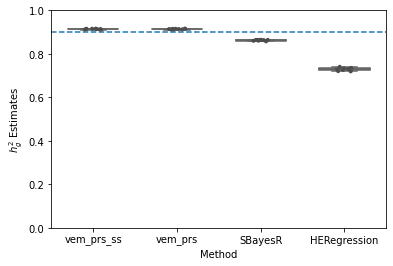

In [11]:
ldp_gs.h2g = 0.9
res = evaluate_heritability_w_simulations([vem_prs_ss(ldp_gs), vem_prs(ldp_gs), SBayesR(ldp_gs), HERegression(ldp_gs)], ldp_gs, n_traits=10)
plot_heritability_boxplot(res, true_h2=0.9)

In [344]:
ldp_gs.pis, ldp_gs.gammas, ldp_gs.mixture_assignment

((0.95, 0.02, 0.02, 0.01),
 array([0.  , 0.01, 0.1 , 1.  ]),
 {0: array([[1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         ...,
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0]])})

In [241]:
res

,vem_prs_ss,SBayesR,HERegression
0,0.895623,0.376363,1.06202
1,0.896063,0.376514,1.06194
2,0.899666,0.377368,1.06123
3,0.895269,0.378647,1.05992
4,0.900735,0.377541,1.05207


Converged at iteration 30 | ELBO: -8741.294753051205


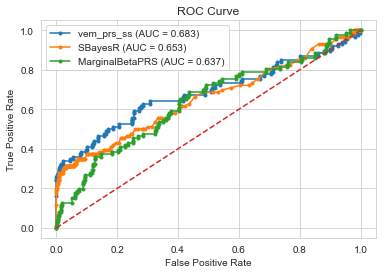

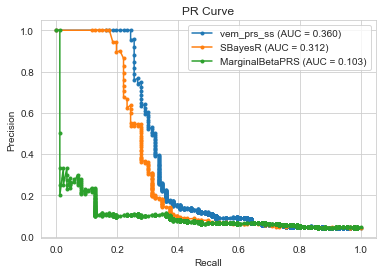

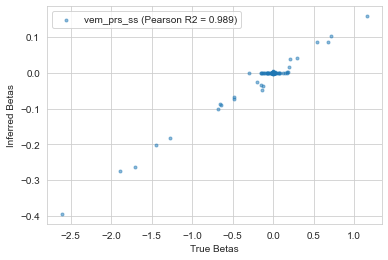

In [425]:
ldp_gs.h2g = .5
ldp_gs.pi = 0.1
ldp_gs.simulate(reset_beta=True)
m_beta = MarginalBetaPRS(ldp_gs)
m_beta.fit()
vx_ind = vem_prs_ss(ldp_gs)
vx_ind.fit(vectorize=False)
sbayesr = SBayesR(ldp_gs)
sbayesr.fit()
plot_roc_curves([vx_ind, sbayesr, m_beta], ldp_gs)
plot_pr_curves([vx_ind, sbayesr, m_beta], ldp_gs)
plot_beta_correlation([vx_ind], ldp_gs)

In [131]:
ldp_gs.h2g = 0.3
ldp_gs.pis = (0.95, 0.02, 0.02, 0.01)
ldp_gs.simulate(reset_beta = True)

models = [TrueBetaPRS(ldp_gs), vem_prs_ss(ldp_gs), SBayesR(ldp_gs), LDPred(ldp_gs), MarginalBetaPRS(ldp_gs)]

res = evaluate_prediction_w_simulations(models, ldp_gs, n_traits=5, k=5)

> Processing Trait 0
Cross validation iteration 0
Converged at iteration 30 | ELBO: -8151.022883275806
Cross validation iteration 1
Converged at iteration 16 | ELBO: -8563.863706006909
Cross validation iteration 2
Converged at iteration 14 | ELBO: -8557.636890355998
Cross validation iteration 3
Converged at iteration 13 | ELBO: -8546.766324594433
Cross validation iteration 4
Converged at iteration 14 | ELBO: -8595.225156325838
> Processing Trait 1
Cross validation iteration 0
Converged at iteration 26 | ELBO: -8115.843154475237
Cross validation iteration 1
Converged at iteration 16 | ELBO: -8569.772728905871
Cross validation iteration 2
Converged at iteration 16 | ELBO: -8535.210924478039
Cross validation iteration 3
Converged at iteration 14 | ELBO: -8538.533193442727
Cross validation iteration 4
Converged at iteration 16 | ELBO: -8572.381020468385
> Processing Trait 2
Cross validation iteration 0
Converged at iteration 48 | ELBO: -8122.04260459013
Cross validation iteration 1
Converg

  0%|          | 0/5 [00:00<?, ?it/s]

> Processing Trait 0
Cross validation iteration 0
Converged at iteration 33 | ELBO: -8833.967675561658
Converged at iteration 33 | ELBO: -8833.967676
Cross validation iteration 1
Converged at iteration 50 | ELBO: -8818.957376107453
Converged at iteration 50 | ELBO: -8818.957376
Cross validation iteration 2
Converged at iteration 29 | ELBO: -8791.295820941348
Converged at iteration 29 | ELBO: -8791.295821
Cross validation iteration 3
Converged at iteration 35 | ELBO: -8809.11197458915
Converged at iteration 35 | ELBO: -8809.111975
Cross validation iteration 4
Converged at iteration 33 | ELBO: -8806.963014700548
Converged at iteration 33 | ELBO: -8806.963015


 20%|██        | 1/5 [00:48<03:12, 48.02s/it]

> Processing Trait 1
Cross validation iteration 0
Converged at iteration 76 | ELBO: -8815.874306141122
Converged at iteration 76 | ELBO: -8815.874306
Cross validation iteration 1
Converged at iteration 37 | ELBO: -8824.58529113371
Converged at iteration 37 | ELBO: -8824.585291
Cross validation iteration 2
Converged at iteration 52 | ELBO: -8803.828608585114
Converged at iteration 52 | ELBO: -8803.828609
Cross validation iteration 3
Converged at iteration 40 | ELBO: -8830.717910424322
Converged at iteration 40 | ELBO: -8830.717910
Cross validation iteration 4
Converged at iteration 59 | ELBO: -8793.240453186105
Converged at iteration 59 | ELBO: -8793.240453


 40%|████      | 2/5 [01:48<02:35, 51.85s/it]

> Processing Trait 2
Cross validation iteration 0
Converged at iteration 42 | ELBO: -8826.417495327396
Converged at iteration 42 | ELBO: -8826.417495
Cross validation iteration 1
Converged at iteration 36 | ELBO: -8842.745958619902
Converged at iteration 36 | ELBO: -8842.745959
Cross validation iteration 2
Converged at iteration 45 | ELBO: -8812.97977742126
Converged at iteration 45 | ELBO: -8812.979777
Cross validation iteration 3
Converged at iteration 44 | ELBO: -8838.400259719505
Converged at iteration 44 | ELBO: -8838.400260
Cross validation iteration 4
Converged at iteration 53 | ELBO: -8824.246836792707
Converged at iteration 53 | ELBO: -8824.246837


 60%|██████    | 3/5 [02:44<01:46, 53.06s/it]

> Processing Trait 3
Cross validation iteration 0
Converged at iteration 50 | ELBO: -8856.480157277234
Converged at iteration 50 | ELBO: -8856.480157
Cross validation iteration 1
Converged at iteration 36 | ELBO: -8858.228133719334
Converged at iteration 36 | ELBO: -8858.228134
Cross validation iteration 2
Converged at iteration 46 | ELBO: -8826.532245211914
Converged at iteration 46 | ELBO: -8826.532245
Cross validation iteration 3
Converged at iteration 48 | ELBO: -8842.161651210572
Converged at iteration 48 | ELBO: -8842.161651
Cross validation iteration 4
Converged at iteration 34 | ELBO: -8837.149388811236
Converged at iteration 34 | ELBO: -8837.149389


 80%|████████  | 4/5 [03:38<00:53, 53.36s/it]

> Processing Trait 4
Cross validation iteration 0
Converged at iteration 43 | ELBO: -8832.004973335173
Converged at iteration 43 | ELBO: -8832.004973
Cross validation iteration 1
Converged at iteration 33 | ELBO: -8817.373279578882
Converged at iteration 33 | ELBO: -8817.373280
Cross validation iteration 2
Converged at iteration 40 | ELBO: -8823.508813132417
Converged at iteration 40 | ELBO: -8823.508813
Cross validation iteration 3
Converged at iteration 43 | ELBO: -8820.066827393228
Converged at iteration 43 | ELBO: -8820.066827
Cross validation iteration 4
Converged at iteration 59 | ELBO: -8818.578921916947
Converged at iteration 59 | ELBO: -8818.578922


100%|██████████| 5/5 [04:33<00:00, 54.79s/it]


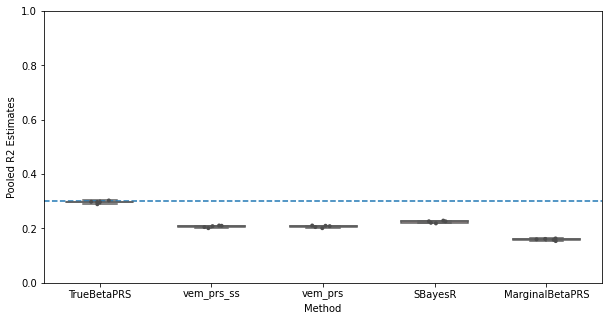

In [17]:
ldp_gs.h2g = 0.3
ldp_gs.pis = (0.9, 0.0, 0.0, 0.1)
ldp_gs.gammas = np.array((0., 0., 0., 1.))
ldp_gs.simulate(reset_beta = True)

# LDPred(ldp_gs),

models = [TrueBetaPRS(ldp_gs), vem_prs_ss(ldp_gs), vem_prs(ldp_gs), SBayesR(ldp_gs), MarginalBetaPRS(ldp_gs)]

res = evaluate_prediction_w_simulations(models, ldp_gs, n_traits=5, k=5)
plot_prediction_results(res, ldp_gs.h2g)

In [261]:
res = []
n_traits = 10

for h2 in (.1, .3, .5, .7):
    for p in (.01, .1, .5, 1.):
        ldp_gs.h2g = h2
        ldp_gs.pi = p
        ldp_gs.simulate(reset_beta=True)
        for _ in range(n_traits):
            ldp_gs.simulate()
            v = vem_prs_ss(ldp_gs)
            v.fit()
            res.append({
                'True pi': p,
                'True h2g': h2,
                'Inferred pi': v.pi,
                'Inferred h2g': v.get_heritability()
            })
        
res
        

Converged at iteration 19 | ELBO: -11010.18069816684
Converged at iteration 19 | ELBO: -11031.503286347475
Converged at iteration 22 | ELBO: -11066.958988828272
Converged at iteration 21 | ELBO: -11047.691126559384
Converged at iteration 17 | ELBO: -11032.339698104513
Converged at iteration 39 | ELBO: -11040.857050773411
Converged at iteration 22 | ELBO: -11037.946242767028
Converged at iteration 116 | ELBO: -11015.930750176889
Converged at iteration 21 | ELBO: -11015.366033936427
Converged at iteration 34 | ELBO: -11036.969576746755
Converged at iteration 36 | ELBO: -11224.108730294753
Converged at iteration 32 | ELBO: -11165.789260965776
Converged at iteration 54 | ELBO: -11174.544253486487
Converged at iteration 34 | ELBO: -11163.786987245361
Converged at iteration 41 | ELBO: -11192.762182167104
Converged at iteration 63 | ELBO: -11192.899313165279
Converged at iteration 35 | ELBO: -11193.649723321567
Converged at iteration 47 | ELBO: -11185.158309691513
Converged at iteration 36 | 

Converged at iteration 169 | ELBO: -8375.808132214977
Converged at iteration 152 | ELBO: -8582.281234233757
Converged at iteration 109 | ELBO: -8546.780717435082
Converged at iteration 142 | ELBO: -8592.79840524193
Converged at iteration 133 | ELBO: -8552.410780112565
Converged at iteration 95 | ELBO: -8579.458686094771
Converged at iteration 175 | ELBO: -8620.995245373984
Converged at iteration 97 | ELBO: -8554.167134628971
Converged at iteration 150 | ELBO: -8595.092814681333
Converged at iteration 111 | ELBO: -8591.757678281712
Converged at iteration 99 | ELBO: -8531.979836421739


[{'True pi': 0.01,
  'True h2g': 0.1,
  'Inferred pi': 0.005996734577096448,
  'Inferred h2g': 0.10791357245944416},
 {'True pi': 0.01,
  'True h2g': 0.1,
  'Inferred pi': 0.008462124647404742,
  'Inferred h2g': 0.10772049414334461},
 {'True pi': 0.01,
  'True h2g': 0.1,
  'Inferred pi': 0.006986448770117525,
  'Inferred h2g': 0.09322488055180399},
 {'True pi': 0.01,
  'True h2g': 0.1,
  'Inferred pi': 0.0059751360087864774,
  'Inferred h2g': 0.09742219815146615},
 {'True pi': 0.01,
  'True h2g': 0.1,
  'Inferred pi': 0.006565770242287057,
  'Inferred h2g': 0.10934086755624148},
 {'True pi': 0.01,
  'True h2g': 0.1,
  'Inferred pi': 0.007462949829486049,
  'Inferred h2g': 0.11008256704951282},
 {'True pi': 0.01,
  'True h2g': 0.1,
  'Inferred pi': 0.006861194549619503,
  'Inferred h2g': 0.09851860734798076},
 {'True pi': 0.01,
  'True h2g': 0.1,
  'Inferred pi': 0.007042739162035145,
  'Inferred h2g': 0.10672643856194092},
 {'True pi': 0.01,
  'True h2g': 0.1,
  'Inferred pi': 0.009462

In [264]:
df = pd.DataFrame(res).sort_values(['True pi', 'True h2g'])
df

,True pi,True h2g,Inferred pi,Inferred h2g
0,0.01,0.1,0.005997,0.107914
1,0.01,0.1,0.008462,0.107720
2,0.01,0.1,0.006986,0.093225
3,0.01,0.1,0.005975,0.097422
4,0.01,0.1,0.006566,0.109341
...,...,...,...,...
155,1.00,0.7,0.232972,0.594281
156,1.00,0.7,0.236034,0.582226
157,1.00,0.7,0.239209,0.598242
158,1.00,0.7,0.218046,0.592563


/Users/szabad/opt/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/szabad/opt/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


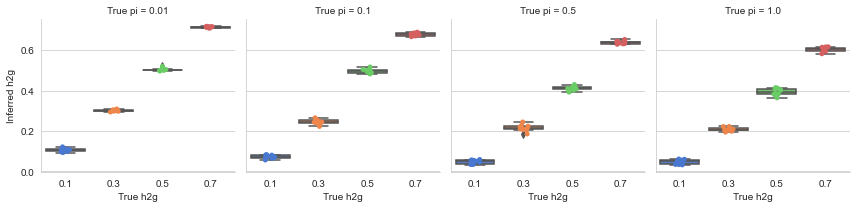

In [278]:
facet_by = 'pi'
plot_inf = 'h2g'

sns.set_style('whitegrid')
g = sns.FacetGrid(df, col=f'True {facet_by}', col_order=np.unique(df[f'True {facet_by}']))
g.map(sns.boxplot, f'True {plot_inf}', f'Inferred {plot_inf}', palette='muted')
g.map(sns.stripplot, f'True {plot_inf}', f'Inferred {plot_inf}', palette='muted')
sns.set_style()

In [295]:
ldp_gs.h2g = 0.1
v = vem_prs_ss(ldp_gs)
v.fit()
plot_beta_correlation([v], ldp_gs)

Converged at iteration 75 | ELBO: -7323.747514777666


TypeError: unsupported format string passed to numpy.ndarray.__format__

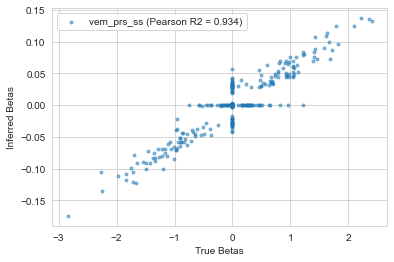

In [297]:
plot_beta_correlation([v], ldp_gs)

In [1]:
ldp_gs = GWASSimulator("ldpred/tests/test_data/sim1_0_train",
                       compute_ld=True,
                       pis=(0.9, 0.1),
                       gammas=(0.0, 1))
ldp_gs.simulate()

NameError: name 'GWASSimulator' is not defined

Converged at iteration 32 | ELBO: -3280.712520934153


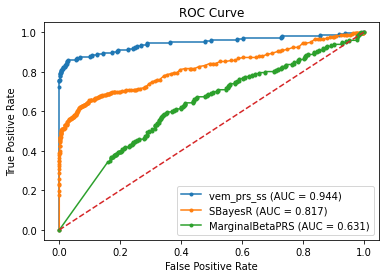

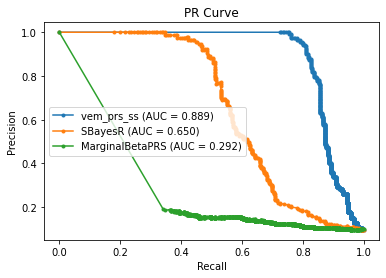

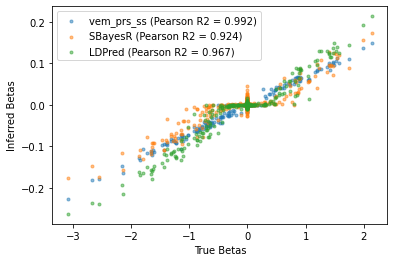

In [13]:
ldp_gs.h2g = .9
ldp_gs.simulate(reset_beta=True)
m_beta = MarginalBetaPRS(ldp_gs)
m_beta.fit()
vx_ind = vem_prs_ss(ldp_gs)
vx_ind.fit(vectorize=False)
sbayesr = SBayesR(ldp_gs)
sbayesr.fit()
ldp = LDPred(ldp_gs)
ldp.fit()
plot_roc_curves([vx_ind, sbayesr, m_beta], ldp_gs)
plot_pr_curves([vx_ind, sbayesr, m_beta], ldp_gs)
plot_beta_correlation([vx_ind, sbayesr, ldp], ldp_gs)

# SBayesR Data 

In [93]:
sbr_gs = GWASSimulator("gctb_2.0_tutorial/data/1000G_eur_chr22",
                       pis=(0.95, 0.02, 0.02, 0.01),
                       gammas=(0.0, 0.01, 0.1, 1),
                       compute_ld=True)
sbr_gs.simulate()

[autoreload of gwasimulator.GWASDataLoader failed: Traceback (most recent call last):
  File "/Users/szabad/opt/miniconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/szabad/opt/miniconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/szabad/opt/miniconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/szabad/opt/miniconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames

> Reading genotype files...
> Computing LD matrices...


In [420]:
sbr = SBayesR(sbr_gs, ldm="gctb_2.0_tutorial/ldm/sparse/chr22/1000G_eur_chr22.ldm.sparse")
sbr.fit()

In [421]:
sbr.get_heritability()

0.502283

In [17]:
v_prs = vem_prs_ss(sbr_gs)
%timeit v_prs.fit(max_iter=1)

Max iterations reached without convergence. You may need to run the model for more iterations.
Max iterations reached without convergence. You may need to run the model for more iterations.
Max iterations reached without convergence. You may need to run the model for more iterations.
Max iterations reached without convergence. You may need to run the model for more iterations.
Max iterations reached without convergence. You may need to run the model for more iterations.
Max iterations reached without convergence. You may need to run the model for more iterations.
Max iterations reached without convergence. You may need to run the model for more iterations.
Max iterations reached without convergence. You may need to run the model for more iterations.
10.4 s ± 381 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


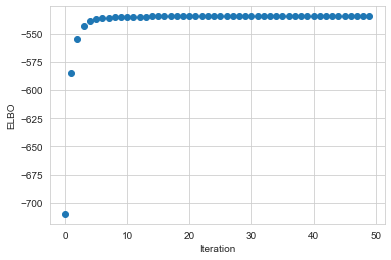

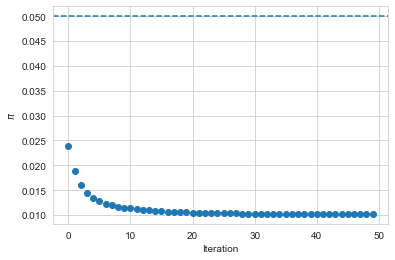

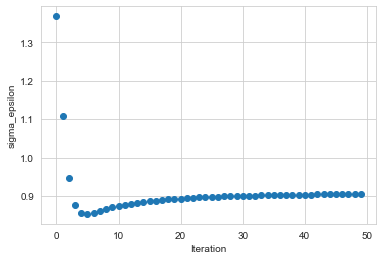

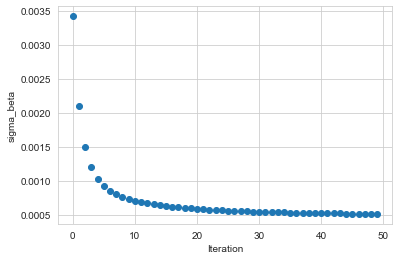

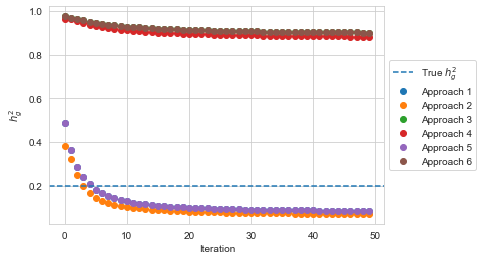

In [423]:
plot_history(v_prs)

In [112]:
gctb_gs = GWASDataLoader("gctb_2.0_tutorial/data/1000G_eur_chr22",
                         phenotype_file="gctb_2.0_tutorial/pheno/phenos_ga1.txt",
                         standardize_genotype=True,
                         standardize_phenotype=True)

gctb_gs.to_sumstats_table()

> Reading genotype files...
> Reading phenotype files...


,CHR,POS,SNP,BETA,Z,SE,PVAL,MAF,A1,A2,N
rs131538,22,16871137,rs131538,-0.072691,-1.413270,0.051434,0.157576,0.066138,A,G,378
rs9605903,22,17054720,rs9605903,0.061524,1.196163,0.051434,0.231633,0.264550,C,T,378
rs5746647,22,17057138,rs5746647,-0.013351,-0.259564,0.051434,0.795200,0.052910,G,T,378
rs16980739,22,17058616,rs16980739,-0.014042,-0.273008,0.051434,0.784847,0.148148,T,C,378
rs9605923,22,17065079,rs9605923,0.068205,1.326059,0.051434,0.184820,0.263228,A,T,378
...,...,...,...,...,...,...,...,...,...,...,...
rs8137951,22,51165664,rs8137951,-0.044963,-0.874184,0.051434,0.382018,0.296296,A,G,378
rs2301584,22,51171497,rs2301584,-0.049476,-0.961922,0.051434,0.336089,0.193122,A,G,378
rs3810648,22,51175626,rs3810648,0.035936,0.698683,0.051434,0.484750,0.062169,G,A,378
rs2285395,22,51178090,rs2285395,0.041033,0.797768,0.051434,0.425005,0.059524,A,G,378


In [113]:
pd.read_csv("sim_1.assoc.linear", sep="\s+")

,CHR,SNP,BP,A1,TEST,NMISS,BETA,STAT,P
0,22,rs131538,16871137,A,ADD,378,-0.072690,-1.41300,0.1584
1,22,rs9605903,17054720,C,ADD,378,0.061520,1.19500,0.2327
2,22,rs5746647,17057138,G,ADD,378,-0.013350,-0.25890,0.7959
3,22,rs16980739,17058616,T,ADD,378,-0.014040,-0.27230,0.7855
4,22,rs9605923,17065079,A,ADD,378,0.068210,1.32600,0.1858
...,...,...,...,...,...,...,...,...,...
15933,22,rs8137951,51165664,A,ADD,378,-0.044960,-0.87280,0.3834
15934,22,rs2301584,51171497,A,ADD,378,-0.049480,-0.96060,0.3374
15935,22,rs3810648,51175626,G,ADD,378,0.035940,0.69730,0.4861
15936,22,rs2285395,51178090,A,ADD,378,0.041030,0.79630,0.4263


In [145]:
prse = PRSEvaluator([vem_prs_ss(ldp_gs), SBayesR(ldp_gs), LDPred(ldp_gs)], ldp_gs)
prse.fit_models()

0.0
None
None
0.2846004901928462
0.28567
None


In [154]:
evaluate_heritability_w_simulations([vem_prs_ss(ldp_gs), SBayesR(ldp_gs), HERegression(ldp_gs)], ldp_gs, n_traits=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Evaluating Heritability with Simulations...


100%|██████████| 5/5 [00:49<00:00,  9.90s/it]


,vem_prs_ss,SBayesR,HERegression
0,0.271939,0.279842,0.347772
1,0.271598,0.279842,0.347772
2,0.272166,0.279842,0.347772
3,0.272166,0.279842,0.347772
4,0.266703,0.279842,0.347772


In [158]:
ldp_gs.h2g = 0.3
ldp_gs.pis = (0.95, 0.02, 0.02, 0.01)
ldp_gs.simulate(reset_beta = True)

models = [TrueBetaPRS(ldp_gs), vem_prs_ss(ldp_gs), SBayesR(ldp_gs), LDPred(ldp_gs), MarginalBetaPRS(ldp_gs)]

res = evaluate_prediction_w_simulations(models, ldp_gs, n_traits=5, k=5)
plot_prediction_results(res, ldp_gs.h2g)

> Processing Trait 0
Cross validation iteration 0
Converged at iteration 14 | ELBO: -8551.954852848727
Cross validation iteration 1
Converged at iteration 17 | ELBO: -8551.954852845123


KeyboardInterrupt: 